# PRODUCT CLASSIFICATION
**I have documented my complete approach with decisions taken at each and every point. I have also written about the conclusion derived from plots and data.**

**SOME PROBLEMS FACED:**
Training and ploting on the complete dataset was beyond the scope of my laptop. So I have trained the model on 
a small subset(almost 10 percent of the data). I used a online virtual machine to increase the speed of the task.

**MY APPROACH IN SHORT**
1. The description and the title together are a robust feature, because both of them represent the product.
2. Since the descriptions and titles in the train and the test data are different, we have to represet the features in a way that represents meaning.
3. I chose to use pretrained embedding. Since similar words in the embedding space are closer, this way the product discription which are similar will be closer to each other.
4. Then I took a weighted mean of the embeddings to get the resultant embedding of the sentence. I used TFID for weighting purpose because words which occur the most are not the ones which convey the most meaning.
5. I created a baseline  using some classifiers. 
6. The one which worked the best was chosen for the submission(Though I thought of ensemble of those models).


In [367]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords   
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below
from tqdm import tqdm
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import time
from wordcloud import WordCloud

In [368]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words=stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/satinder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/satinder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [369]:
train_data = pd.read_csv("training.tsv",sep="\t")
test_data = pd.read_csv("test1.csv",sep="\t")


In [370]:
train_data.shape

(1200000, 3)

In [371]:
test_data.shape

(92, 3)

In [372]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   title        1199998 non-null  object
 1   description  1200000 non-null  object
 2   category     1200000 non-null  object
dtypes: object(3)
memory usage: 27.5+ MB


In [373]:
# title has 2 null values

In [374]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        92 non-null     object
 1   description  76 non-null     object
 2   category     92 non-null     object
dtypes: object(3)
memory usage: 2.3+ KB


In [375]:
# Description has some null values

In [376]:
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",500)
pd.options.display.max_seq_items=500

In [377]:
train_data.head(100)

,title,description,category
0,ZicZac // Black + Red (Euro: 44),Clothing & related products (B2C) - Shoes and ...,R
1,9X9 RESISTA/484938,Publishing/Printing - Printing Services,S
2,Halle Pant - Short Inseam 013049561D0010001_ 02,Clothing & related products (B2C) - General,R
3,Harry Houser Travel Expenses - Meals,Security - personnel,S
4,Tee Time: 740078609 : Greens Fee - Composite,Admissions - Green Fees for Privately Owned Go...,R
5,Flat Rate (5-7 Business Days) Shipping line: 4...,Shipping Only - common carrier - FOB destination,R
6,Travel to Water Batteries Plant 1 During regul...,Repair (other) - Performed on TPP (labor only),S
7,F5 Networks Consulting Services Standard Hourl...,Installation - associated with the sale of TPP...,S
8,Network Time and Materials Services - May 2019...,Consulting - Systems,S
9,2c92a0ad707bb947017095aa4a973307,Cloud Services-Platform as a Service (PaaS),S


In [378]:
def plotWordCloud(data, column, category=["R","S"]):
    
    for i in category:
        descriptions = train_data[train_data["category"]==i].loc[:,column].unique().tolist()
        dic = {}
        for sentences in descriptions:
            for token in word_tokenize(sentences):
                token=token.lower()
                if token.isalpha():
                    if token in dic.keys():
                        dic[token] += 1
                    else:
                        dic[token] = 1
        wordcloud=WordCloud(width=1200,height=800).generate_from_frequencies(frequencies=dic)
        plt.figure(figsize = (24, 24), facecolor = None) 
        plt.title(i+" category")
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0)



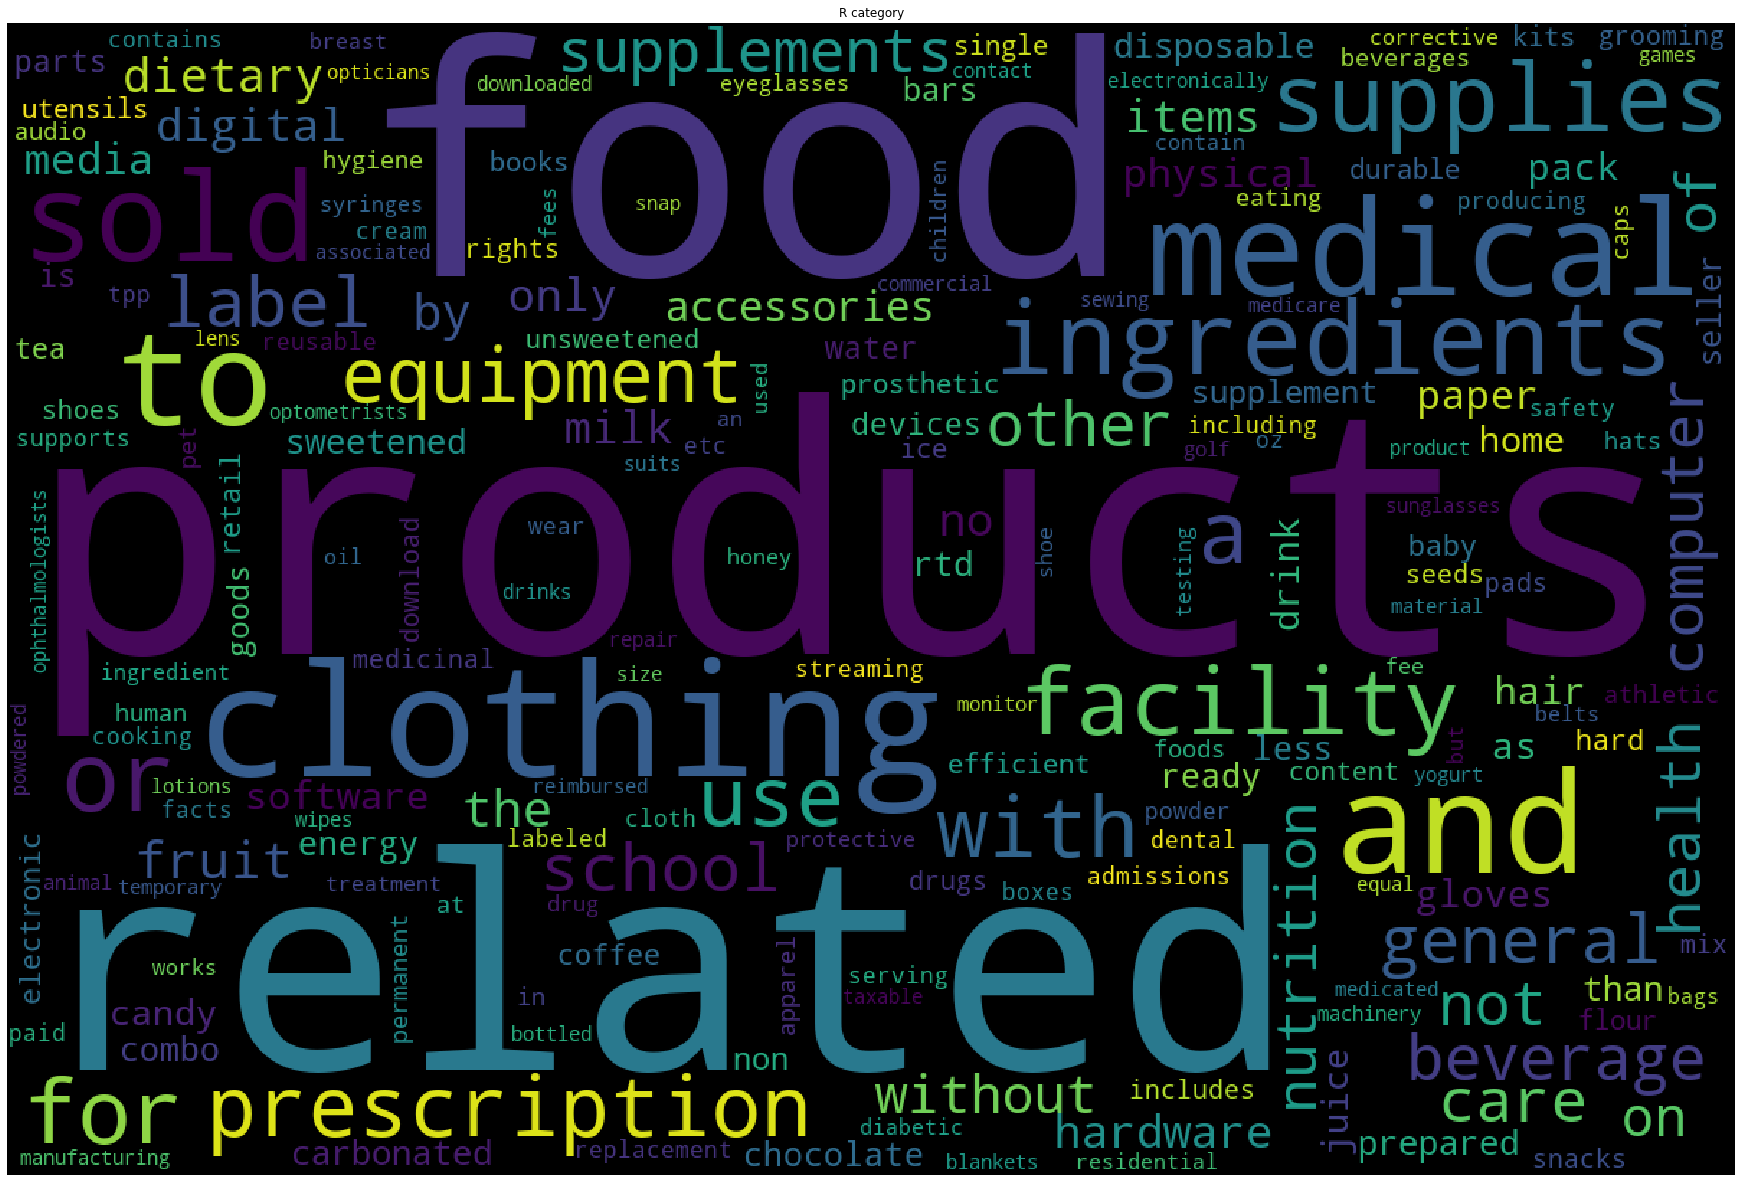

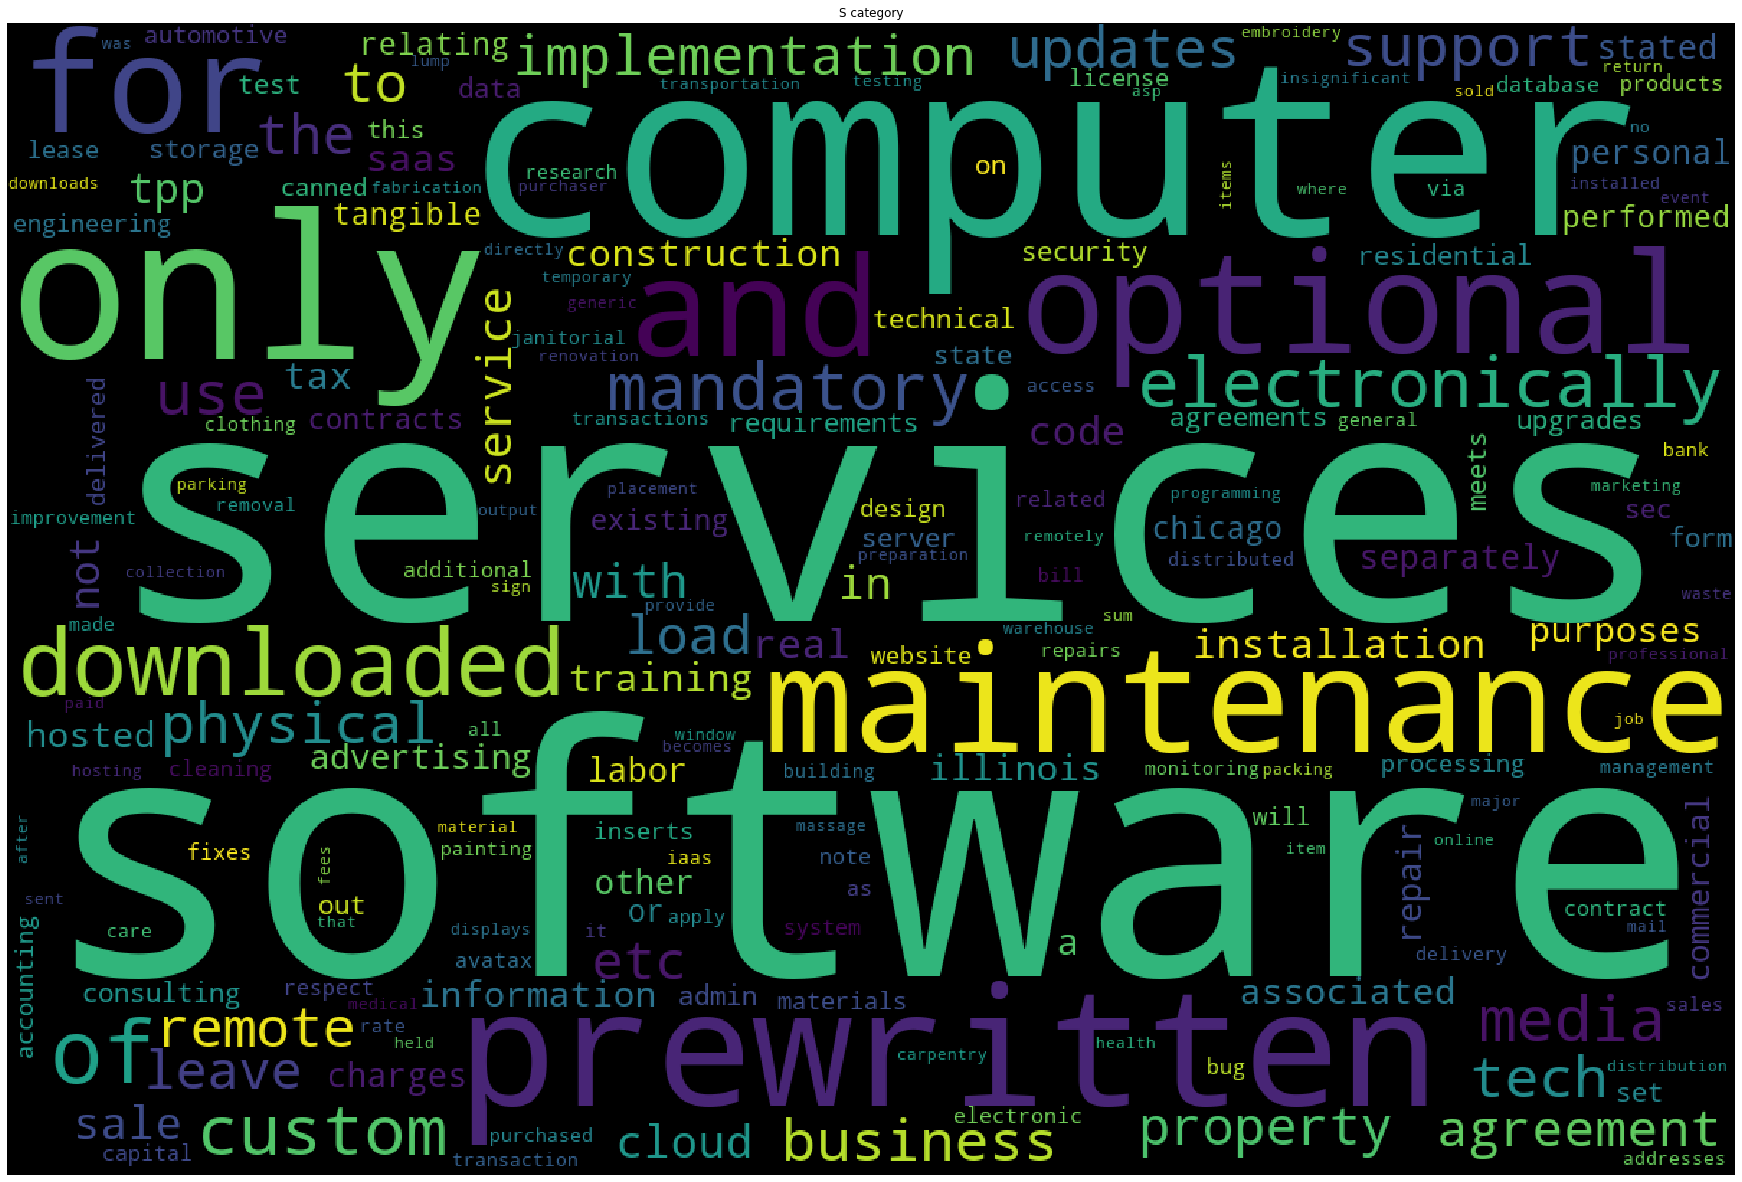

In [379]:
plotWordCloud(train_data,"description") # words clouds for the description field

In [381]:
plotWordCloud(train_data.iloc[:1000],"title")

#### Looks like the R category contains things which humans use in their daily life like
1. Clothing
2. Food
3. Video streaming services
4. blankets, bedding etc.

#### Also the S category has things like
1. Computers
2. Services
3. Software


### Let us have a second look to confirm it

In [382]:
def printUnique(data,category,column):
    unique = (data[data["category"]==category][column].unique()) 
    print("{} unique values in the {} column of category {}".format(len(unique),column,category))
    print(unique)

In [383]:
printUnique(train_data,"R","description")

963 unique values in the description column of category R
['Clothing & related products (B2C) - Shoes and shoe laces'
 'Clothing & related products (B2C) - General'
 'Admissions - Green Fees for Privately Owned Golf Course'
 'Shipping Only - common carrier - FOB destination ' 'Testing strips'
 'Movies - Streaming / electronic download'
 'Other Digital Goods -- No Physical Media'
 'Digital Audio Visual Works (with rights conditioned on continued payments)'
 'Music' 'Tangible Personal Property (TPP)'
 'Temporary Unmapped TPP SKU - taxable default'
 'Clothing & related products (B2C) - Children only'
 'Food & Food Ingredients - Coffee (powder and beans)'
 'Clothing & related products (B2C) - Cosmetics'
 "Audio Products (tapes, cd's etc.)"
 'Clothing & related products (B2C) - Jewelry' 'Office Supplies'
 'Accessories - Containers' 'Clothing & related products (B2B) - Sneakers'
 'Promotional Merchandise'
 'Clothing & related products (B2C) - Hats and caps'
 'Grooming /other - Creams and lot

In [384]:
printUnique(train_data,"S","description")

332 unique values in the description column of category S
['Publishing/Printing - Printing Services' 'Security - personnel'
 'Repair (other) - Performed on TPP (labor only)'
 'Installation - associated with the sale of TPP (equipment/parts and labor) - separately stated'
 'Consulting - Systems' 'Cloud Services-Platform as a Service (PaaS)'
 'ASP - hosted software, server not in state'
 'Butchering and Meat Services' 'Website - Information access'
 'Data - processing - electronic output'
 'Embroidery services with sale of clothing' 'Website - Hosting'
 'Cloud Services - SaaS - Service Agreement - For Illinois purposes only:  Meets requirements of 5-part test for purposes of Illinois set out in 86 Ill. Admin Code Sec. 130.1935(a)(1) *See Additional AvaTax System Tax Code Information'
 'Professional Services' 'Advertising - Media'
 'Security - Background Checks'
 'Cloud Services - SaaS - Service Agreement'
 'Janitorial - Non residential'
 'Computer Software Maintenance (prewritten softwar

In [385]:
printUnique(train_data,"R","title")

599778 unique values in the title column of category R
['ZicZac // Black + Red (Euro: 44)'
 'Halle Pant - Short Inseam 013049561D0010001_ 02'
 'Tee Time: 740078609 : Greens Fee - Composite' ...
 'Video Rental (order # 215505199)'
 'Hope For All Rhinestone RIbbon Tee - L'
 'AriaCounterpart (order # 304541704)']


In [386]:
printUnique(train_data,"S","title")

595680 unique values in the title column of category S
['9X9 RESISTA/484938' 'Harry Houser Travel Expenses - Meals'
 'Travel to Water Batteries Plant 1 During regular business hours' ...
 'Repair of LNW170 PN:109642728'
 'Gafford Family Medicine: First DataBank Drug Database - Coverage dates: 5/1/2016-5/31/2016'
 'Premium support renewal, PA-5220  Serial Number: 013201004369']


Only 1295 kind of descriptions !!!!. Also our assumption about the descriptions was right
Also there are almost 11 lakh 90 thousand unique titles maybe these can be used to impute values in the
**TEST DATA**

In [387]:
# It can be a classification task

In [388]:
labe = LabelEncoder()
labe.fit(train_data["category"])
train_data["category"]=labe.fit_transform(train_data["category"])
test_data["category"]=labe.fit_transform(test_data["category"])

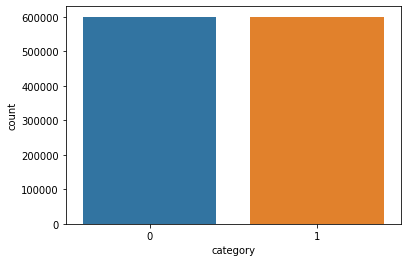

In [389]:
sns.countplot(x="category",data=train_data)

In [390]:
# No class imbalance

In [391]:
# Lets have a look at the most occuring descriptions

In [392]:
train_data["description"].value_counts()

Clothing & related products (B2C) - General                      136636
Movies - Streaming / electronic download                          85856
ASP - hosted software, server not in state                        79174
Tangible Personal Property (TPP)                                  52664
Website - Hosting                                                 44697
                                                                  ...  
Clothing & related products (B2B) - Scarves                           1
Clothing & related products (B2B) - Bandanas                          1
Sensors and accessories-Sold to Medical Facility                      1
Clothing & related products (B2B) - Sweatbands                        1
Food & Food Ingredients - Water (flavored bottled, sweetened)         1
Name: description, Length: 1295, dtype: int64

In [393]:
# LOOKS like not all descriptions are that frequent

In [394]:
# Let us check these for different categories

In [395]:
train_data[train_data["category"]==0]["description"].value_counts() # R category

Clothing & related products (B2C) - General                                                                                                                      136636
Movies - Streaming / electronic download                                                                                                                          85856
Tangible Personal Property (TPP)                                                                                                                                  52664
Admissions - Green Fees for Privately Owned Golf Course                                                                                                           27969
Clothing & related products (B2C) - Socks and stockings                                                                                                           18431
                                                                                                                                                                

In [396]:
train_data[train_data["category"]==1]["description"].value_counts() # S category

ASP - hosted software, server not in state                                                                                                                                                                                                                      79174
Website - Hosting                                                                                                                                                                                                                                               44697
Cloud Services - SaaS - Service Agreement                                                                                                                                                                                                                       42135
Website - Domain Registration                                                                                                                                                                                         

In [397]:
# This can be helpfull while filling NA values in the test set

In [398]:
# Let the get some insights out of the test data

In [399]:
# Let us check for title column as well

In [400]:
train_data[train_data["category"]==0]["title"].value_counts()

FIP dark grey wall name plate with white vinyl, -  [Nameplate |Table 5A] [Firm Price]\    5
1 SKID:\                                                                                  5
Description:\                                                                             4
LINE LIMIT TEST                                                                           3
Description: \                                                                            3
                                                                                         ..
Tee Time: 956329507 : Greens Fee - Composite                                              1
1-Pack Line item: 1390075314246 Variant: 16850486149                                      1
1 Case of SmartMix TT Sales 2012-23864181-1                                               1
2c92a00b6f31fe45016f56990a656ef6                                                          1
Seven Days of Dazzle  66665328-001-001   LINE                                   

In [401]:
train_data[train_data["category"]==1]["title"].value_counts()

Model #\                                                                                   33
FSC - Loomis 6 Day, 1st year  INSIDE LIFTGATE DELIVERY\                                    26
PSC - Brinks, expires 5 years  LIFTGATE INSIDE DELIVERY\                                   17
PSC - Brinks, expires 5 years  LIFT/GATE INSIDE DELIVERY\                                  16
1\                                                                                         15
                                                                                           ..
Job 1203974                                                                                 1
Lead:7620000 for Phone Number: (845) 221-1587, zip code:  Lead offered on 04 Mar 10:14.     1
WRLS_C31573-908-17                                                                          1
Domain Renewal - newusedelectricmotor.com - 1 Year/s (02/01/2016 - 01/31/2017)              1
Camera System Fee (33 Units x $6.50 per unit, per month)    

In [402]:
# if the title values are repeated multiple times then this title -> description may have been added to 
# create bias in the classifier

In [403]:
# Let us check if there are repetitions in the data
print("{} repeated records in the data".format(train_data[train_data.duplicated()].shape[0]))

4045 repeated records in the data


In [36]:
# Let us remove this data because this will create bias.
# train_data.drop_duplicates(subset=list(train_data), keep="first",inplace=True)

### Till now the observations are:
1. There are some number of unique description, maybe this can be a classification problem if the test data also consists of these descriptions only.
2. There are a large number of unique title values, some of them were repeated and were removed.
3. The train data is class balanced.


In [404]:
# Let us check if the test data also has the same properties as the train set.

In [405]:
# Class imbalance

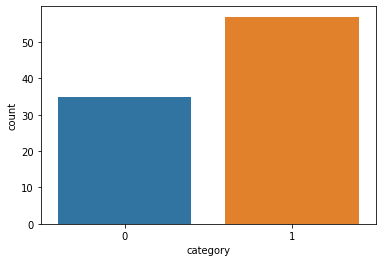

In [406]:
sns.countplot(x="category",data=test_data)

In [407]:
for i in [0,1]:
    for j in ["title","description"]:
        printUnique(test_data,i,j)
        print()

34 unique values in the title column of category 0
['Myo-Aid' 'Bio-Sponge®'
 'UniquepH Multipurpose Solution for Rigid Gas Permeable (RGP) contact lenses'
 'Platinum DHA' 'Supplements for Horses' 'Prom/Formal Dress' 'Olive Oil'
 'Chocolate Mint Snack Bar (9 Pack)' 'Supplements for Dogs' 'Watches'
 'Seasoning' 'Jeans' 'Outerwear' 'Jewellery' 'Merchandise - Jackets'
 'Bras' 'Ortho-Chon®' 'Sunglasses'
 'Granola Minis - Chocolate Banana (4 Pack)' 'Lacripure Saline Solution'
 'Playsuit/Romper' 'Crispy Squares - Chocolate Chip (6 Pack)'
 'Nutritional Yeast' 'Platinum Longevity®' 'Performance Minerals™'
 'Products' 'BCAA Plus' 'Vitamin D3' 'MSM'
 'Soft Baked Mini Cookies - Apple Cinnamon (5 Pack)'
 "Platinum Women's Multi-Vitamin" 'Glucosamine Sulfate for You'
 'Hemo-Flo®' 'Whey Protein']

20 unique values in the description column of category 0
['Human Nutritional Supplements/Vitamin Supplements'
 '4oz bottles, 2.5 oz bottles for sale\n2.5 oz sample bottles to Doctors and Labs at no charge\n

In [408]:
# Does not look like we have the same descriptions and title in the test data
set(((train_data["description"].unique()).tolist()))&set((test_data["description"].unique()).tolist())


set()

In [409]:
res = set(((train_data["title"].unique()).tolist()))&set((test_data["title"].unique()).tolist())
res

{'Application Services',
 'Consulting',
 'Hardware Support',
 'Maintenance',
 'Professional services',
 'Service',
 'Software Maintenance',
 'Support Services',
 'Window Cleaning'}

In [410]:
# No similar discriptions for we have some common titles.

In [411]:
# Let us have a look at the title names of the test data where description is nan.
res & set(test_data[test_data.iloc[:,1].isna()]["title"].values.tolist())

{'Service', 'Window Cleaning'}

So we have **two** title which is common in both the train and the test set and also the descrition of this record in nan. This can be used to fill some nan descriptions later on

**This means for the rest of 14 nan descriptions we need to find some other way out. Also for the title which are common between the train and test data we can simply put the category from the description. Since we don't have the same descriptions we need to extract the meaning of the descriptions.**

In [413]:
test_data

,title,description,category
0,Myo-Aid,Human Nutritional Supplements/Vitamin Supplements,0
1,ASM Community Advertising,Online adverstisemtn on one of ASM electronic ...,1
2,Application Services,"Application Services include access to, and us...",1
3,Carpet Repairs,NaN,1
4,Bio-Sponge®,Human Nutritional Supplements/Vitamin Supplements,0
5,Brandywine Valley Chapter - Metallurgy for the...,Education courses delivered onsite at customer...,1
6,Remove Suction Line Drier,Remove Suction Line Drier <br/><br/> Reclaim a...,1
7,Vct Floor Refinishing,NaN,1
8,UniquepH Multipurpose Solution for Rigid Gas P...,"4oz bottles, 2.5 oz bottles for sale\n2.5 oz s...",0
9,Assets for Snagit,Hosted software service that allows subscriber...,1


In [414]:
# Though the descriptions are different but the insights are applicable here as well, service based
# things belong to the S category are Food or human related things based things 


In [415]:
test_data[test_data["description"].isna()]

,title,description,category
3,Carpet Repairs,NaN,1
7,Vct Floor Refinishing,NaN,1
11,Clean Carpet - Clean Windows - Scrub And Buff ...,NaN,1
20,Apparel Customization : Alterations,NaN,1
24,Auto Scrub And Re Coat Lvt And No Wax Tile Floors,NaN,1
32,extension of labor services,NaN,1
33,Apparel : Uniform Accessories,NaN,1
37,Window Cleaning,NaN,1
41,Bathroom And Vestibule Ssw And Santizing,NaN,1
45,Store Cleaning,NaN,1


In [416]:
# Another observation all the descriptions of S category are Nan, although in this data it maybe intentionally added
# but in real life this can be because of the website from which this data was scraped didn't have descriptions

In [417]:
#count how many unique words are there and how many of those are present in the test set.

In [418]:
def func(train_unique):
    tokens = []
    for i in train_unique:
        try:
            for j in word_tokenize(i):
                if j.isalpha():
                    tokens.append(j)
        except:
            continue
    return (tokens)

In [419]:
def getCommonWords(column,p):
    train_unique = train_data.loc[:,column].unique().tolist()
    test_unique = test_data.loc[:,column].unique().tolist()
    train_tokens=func(train_unique)
    if p==2:
        return train_tokens
    test_tokens=func(test_unique)
    print("{} unique words in the train_data".format(len(train_tokens)))
    print("{} unique words in the test_data".format(len(test_tokens)))
    common_words=set(train_tokens) & set(test_tokens)
    print("{} common words".format(len(common_words)))
    print("-----------------------------")

In [420]:
# getCommonWords("title")
getCommonWords("description",1)

8777 unique words in the train_data
1608 unique words in the test_data
223 common words
-----------------------------


# Preprocessing
The dataset has only 2 columns, both the columns are having string based features. So in order to get the prediction right we have to take out the meaning of the text. There are a lot of ways to represent text. Some of the bag of words representation are:
1. Count vectorizer --> Since we have only few descriptions, this can be explored. But this can lead to sparse vectors and also since the same descriptions are not there in the test data, also order of words is not considered.
2. TfidfVectorizer --> This is a better choice over count vectorizer.

The above two methods are good but, since the test data can have new words in the description, we need some ways to get the synonyms. 
##### will be exploring  GLOVE or WORD2VEC pretrained embeddings.
Since the embedding for similar words are closer in the high dimensional space eaxmple t-shirt and jeans would lie closer in high dimensional space, this can help the model get some insights, out of the words.

In [421]:
# Since the test data will have null values in the description column. We will concatenate both the columns.
def add_feature(): 
    train_data["description"].fillna('',inplace=True)
    train_data["mixed"] = train_data["title"] + " " + train_data["description"]
    test_data["description"].fillna('',inplace=True)
    test_data["mixed"] = test_data["title"] + " " + test_data["description"]
    train_data.drop(["title","description"],axis=1,inplace=True)
    test_data.drop(["title","description"],axis=1,inplace=True)
    
add_feature()
print(train_data.shape,test_data.shape)

(1200000, 2) (92, 2)


In [422]:
def preprocess(d):
    '''
    This function tokenizes the words, remove punctutation and then removes the stop words from the text.
    '''
    data=d.copy()
    tokens=data["mixed"].apply(lambda x:word_tokenize(x.lower()))
    removed_puncutation=tokens.apply(lambda tokens:[word for word in tokens if word.isalpha()])
    removed_stopwords=removed_puncutation.apply(lambda x:[w for w in x if not w in stop_words]) #Sometimes can degrade the accuracy also
    # return removed_puncutation
    data["mixed"]=removed_stopwords
    return data
    

In [423]:
# preprocessed_data

In [424]:
# convert glove embeddings to word2vec
# This has to be used the first time

# from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input_file = 'glove.6B.100d.txt'
# word2vec_output_file = 'word2vec.txt'
# glove2word2vec(glove_input_file, word2vec_output_file)

In [425]:
# Load the embeddings
filename = 'word2vec.txt'
glove = KeyedVectors.load_word2vec_format(filename, binary=False)

In [426]:
glove["good"] # 100 dimensional embedding of word good

array([-0.030769 ,  0.11993  ,  0.53909  , -0.43696  , -0.73937  ,
       -0.15345  ,  0.081126 , -0.38559  , -0.68797  , -0.41632  ,
       -0.13183  , -0.24922  ,  0.441    ,  0.085919 ,  0.20871  ,
       -0.063582 ,  0.062228 , -0.051234 , -0.13398  ,  1.1418   ,
        0.036526 ,  0.49029  , -0.24567  , -0.412    ,  0.12349  ,
        0.41336  , -0.48397  , -0.54243  , -0.27787  , -0.26015  ,
       -0.38485  ,  0.78656  ,  0.1023   , -0.20712  ,  0.40751  ,
        0.32026  , -0.51052  ,  0.48362  , -0.0099498, -0.38685  ,
        0.034975 , -0.167    ,  0.4237   , -0.54164  , -0.30323  ,
       -0.36983  ,  0.082836 , -0.52538  , -0.064531 , -1.398    ,
       -0.14873  , -0.35327  , -0.1118   ,  1.0912   ,  0.095864 ,
       -2.8129   ,  0.45238  ,  0.46213  ,  1.6012   , -0.20837  ,
       -0.27377  ,  0.71197  , -1.0754   , -0.046974 ,  0.67479  ,
       -0.065839 ,  0.75824  ,  0.39405  ,  0.15507  , -0.64719  ,
        0.32796  , -0.031748 ,  0.52899  , -0.43886  ,  0.6740

In [427]:
glove.most_similar("good") # we can see the words similar to good !!

[('better', 0.8931913375854492),
 ('sure', 0.8314563035964966),
 ('really', 0.8297761678695679),
 ('kind', 0.828826904296875),
 ('very', 0.8260800242424011),
 ('we', 0.8234356045722961),
 ('way', 0.8215397596359253),
 ('think', 0.8205099105834961),
 ('thing', 0.8171301484107971),
 ("'re", 0.8141680955886841)]

# Below is an example how this will help in this problem

In [428]:
(glove["jeans"]-glove["pants"]).mean() # almost zero meaning these words will lie closer in the 100 dimensional space

-0.0011437616

In [429]:
vectorizer = TfidfVectorizer()

In [430]:
vectorizer.fit(getCommonWords("mixed",p=2)) # Making a vocab

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [452]:
# We have embedding for words. Now we have to calculate embedding for the complete sentence.
# We will use a basic approach of weighting the embedding on the words based on TFID.

def getVector(tokens, dim):
    vec=np.zeros((1,dim))
    c=0
    for word in tokens:
        try:
            inde=vectorizer.vocabulary_[word]
            # print(inde,vectorizer.idf_.shape,vectorizer.idf_[0,])
            vec+= (vectorizer.idf_[inde]*glove[word]).reshape((1,dim)) 
            c+=1
        except KeyError:
            continue
    if c>0:
        vec/=c
    return vec

In [432]:
def getxY(data):
    '''
    This function returns X and y, namely the training data and the labels.
    '''
    s = time.time()
    preprocessed_data = preprocess(data)
    # preprocessed = preprocess(data)
    print("processed")
    new_col = preprocessed_data["mixed"].apply(lambda x: getVector(x,100).flatten())
    print("embedding of sentence calculated")
    preprocessed_data["embedding"]=new_col
    X = preprocessed_data["embedding"]
    y = preprocessed_data["category"]
    y=y.values.reshape((-1,1))
    newX=[]
    for i in range(len(X)):
        newX.append(X[i])
    newX = np.array(newX)
    e = time.time()
    print("{} seconds taken".format(e-s))
    return newX,y


In [433]:
# My laptop slows down very much, so will be working  on a subset of the datset. Will training the 
# finalized model on Azure. Lets us have a look if there is any class imbalance in the the 1st 1 lakh enteries;

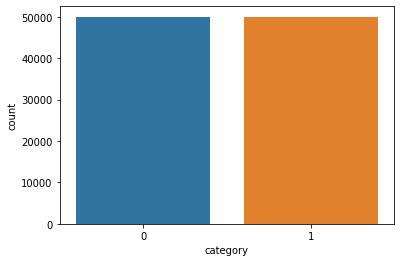

In [434]:
sns.countplot(x="category",data=train_data.iloc[:100000])

In [436]:
# Since the class distribution of the dataset from the complete data is similar to first 1 lakh enteries, 
# We can use this to train the model on the smaller subset.
X,y = getxY(train_data.iloc[:100000])
# train_data.iloc[:1000]000
# Bug: have a look above you are changing the train_data somewhere

processed
embedding of sentence calculated
670.9456820487976 seconds taken


### Let us look if there are clusters formed or not

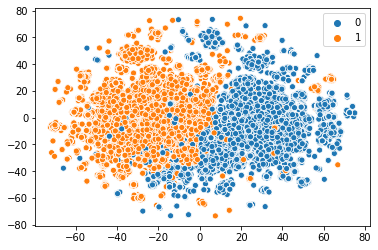

In [437]:
from sklearn.manifold import TSNE
tsne = TSNE()
num_enteries = 40000 # Works to slow for more enteries
X_embedded = tsne.fit_transform(X[:num_enteries])
sns.scatterplot(X_embedded[:num_enteries,0], X_embedded[:num_enteries,1],hue=y[:num_enteries].reshape((-1)))

## We can clearly see 2 clusters

In [260]:
# Will try to plot the decision boundary of the classifier

### Will have to maintain the proportion of each category in both of the datasets, so will use stratification

In [438]:
def getProportion(data):
    x = (data==1).sum()/data.shape[0]
    print("{:.2f} percent R category and {:.2f} percent S category".format((1-x)*100,x*100))

In [440]:
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.05,stratify=train_data.iloc[:100000,0]) 
getProportion(train_y)
getProportion(test_y)

50.02 percent R category and 49.98 percent S category
50.02 percent R category and 49.98 percent S category


In [441]:
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((95000, 100), (5000, 100), (95000, 1), (5000, 1))

In [442]:
# lets us create a baseline
from sklearn.model_selection import cross_val_score
classifiers = [xgb.XGBClassifier(),LogisticRegression(), GaussianNB(), RandomForestClassifier(), DecisionTreeClassifier(),
          KNeighborsClassifier(),MLPClassifier(alpha=1, max_iter=1000)]

names = ["XGB","Logistice Regression","Gaussian NB","Random Forest","Decision Tree",
         "K-nearest","multi layer perceptron"]

trained_models = {}

In [443]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm,model_name):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="g",cmap="Greens")
    ax.set_ylim([0,2])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(model_name); 
    ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([0, 1])
    plt.show()

Using XGB classifier
XGB model with accuracy 99.13. Took 104.50515508651733 seconds
precision: 0.99 recall: 0.99, f1: 0.99, rocauc: 0.99


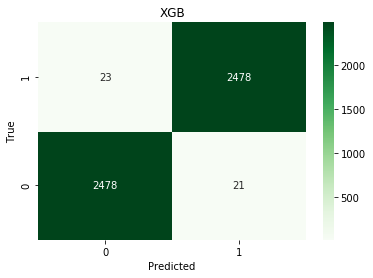

--------------------------------------
Using Logistice Regression classifier


/home/satinder/anaconda3/envs/dw/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/satinder/anaconda3/envs/dw/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Logistice Regression model with accuracy 97.51. Took 6.285789966583252 seconds
precision: 0.98 recall: 0.97, f1: 0.97, rocauc: 0.97


/home/satinder/anaconda3/envs/dw/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


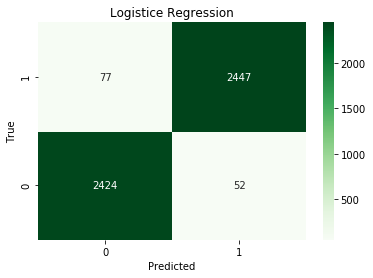

--------------------------------------
Using Gaussian NB classifier
Gaussian NB model with accuracy 91.15. Took 1.1426975727081299 seconds
precision: 0.96 recall: 0.88, f1: 0.92, rocauc: 0.92


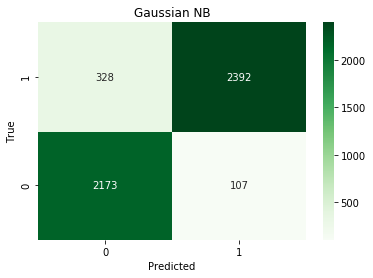

--------------------------------------
Using Random Forest classifier
Random Forest model with accuracy 98.65. Took 456.88180351257324 seconds
precision: 0.99 recall: 0.98, f1: 0.99, rocauc: 0.99


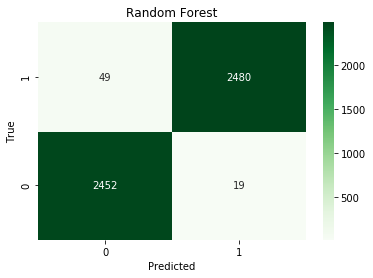

--------------------------------------
Using Decision Tree classifier
Decision Tree model with accuracy 95.95. Took 106.62527680397034 seconds
precision: 0.96 recall: 0.96, f1: 0.96, rocauc: 0.96


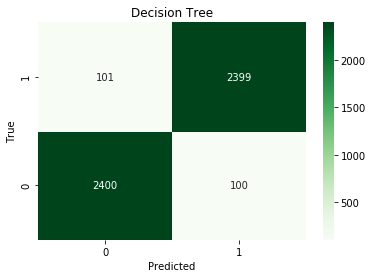

--------------------------------------
Using K-nearest classifier
K-nearest model with accuracy 98.93. Took 960.4064939022064 seconds
precision: 0.99 recall: 0.99, f1: 0.99, rocauc: 0.99


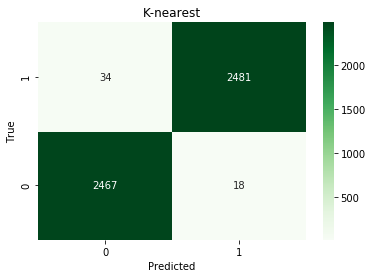

--------------------------------------
Using multi layer perceptron classifier
multi layer perceptron model with accuracy 99.02. Took 178.0247368812561 seconds
precision: 0.99 recall: 0.98, f1: 0.99, rocauc: 0.99


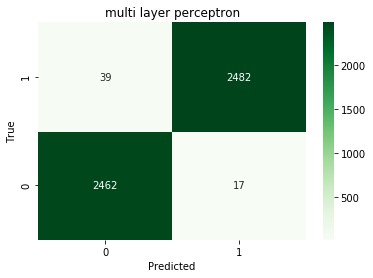

--------------------------------------


In [444]:
# We train different models on the training data and evaluate their performance on the validation set.
# We also plot confusion matrix and then we also print some other metrics apart from accuracy which can be used
# to judge the models perfromance.

for i in range(len(classifiers)):
    s = time.time()
    print("Using {} classifier".format(names[i]))
    
    mod=classifiers[i].fit(train_x,train_y.ravel())
    trained_models[names[i]]=mod
    scores = cross_val_score(classifiers[i], X, y.ravel(), cv=5)
    
    e = time.time()
    
    print("{} model with accuracy {:.2f}. Took {} seconds".format(names[i],scores.mean()*100,e-s))
    cm=confusion_matrix(mod.predict(test_x).reshape((-1,1)),test_y,labels = [0,1])
    predictionn = mod.predict(test_x).reshape((-1,1))
    precision = precision_score(predictionn,test_y)
    recall = recall_score(predictionn,test_y)
    f1 = f1_score(predictionn,test_y)
    rocauc=  roc_auc_score(predictionn,test_y)
    print("precision: {:.2f} recall: {:.2f}, f1: {:.2f}, rocauc: {:.2f}".format(precision,recall,f1,rocauc))
    plot_confusion_matrix(cm,names[i])
    print("--------------------------------------")
    

**The models have performed good as baseliners, but I am afraid they have overfitted. XG bosst, naive bayes and
mlp classifier show promising results. Tree based models can also be regularized by keep a constraint on the 
MAX DEPTH.**

In [270]:
# 4 layer neural network pytorch( Adding dropout)

In [445]:

import torch.nn as nn
from torch.nn.init import xavier_uniform_
from torch.nn.init import kaiming_uniform_
class NN(nn.Module):
    '''
    Model architecture.
    '''
    def __init__(self):
        super(NN,self).__init__()
        self.l1=nn.Linear(100,60)
        kaiming_uniform_(self.l1.weight, nonlinearity='relu')
        self.relu1 = nn.ReLU()
        
        
        self.l2=nn.Linear(60,30)
        kaiming_uniform_(self.l2.weight, nonlinearity='relu')
        self.relu2=nn.ReLU()
        
        self.l3=nn.Linear(30,10)
        kaiming_uniform_(self.l3.weight, nonlinearity='relu')
        self.relu3=nn.ReLU()
        
        self.l4=nn.Linear(10,1)
        xavier_uniform_(self.l4.weight)
        self.sig = nn.Sigmoid() 
        
        self.drop1=nn.Dropout(p=0.2)
        self.drop2=nn.Dropout(p=0.5)
        self.drop3=nn.Dropout(p=0.2)

    def forward(self,x):
        x=self.drop2(self.relu1(self.l1(x)))
        x=self.drop1(self.relu2(self.l2(x)))
        x=self.drop3(self.relu3(self.l3(x)))
        x=self.sig(self.l4(x))
        return x
    
net=NN().double()

In [446]:
from torch.utils.data import Dataset

class loader(Dataset):
    '''
    Data loader class
    '''
    def __init__(self,p,q):
        self.p = p
        self.q = q
    def __len__(self):
        return self.p.shape[0]
    def __getitem__(self,idx):
        return self.p[idx],self.q[idx]

In [447]:
X.shape

(100000, 100)

In [448]:
# d = preprocess(train_data.iloc[:100000])
# new_col=d["description"].apply(lambda x:getVector(x,100).flatten())
# d["embedding"]=new_col
load=loader(X,y) # data loader object

In [449]:
# Performing train test splits

import torch
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader

device=torch.device("cpu")
net=net.double().to(device)

import math
batch_size=64
train_percent=0.90
size = len(load)
print("Data Loaded")
train_size = math.floor(train_percent*size)
test_size = size-train_size
print("Total size of the dataset: ", size)
print("Train data size: ", train_size)
print("Test data size: ", test_size)
print("using {} for training".format(device))
train, validation = torch.utils.data.random_split(load, [train_size, test_size])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers=4)

Data Loaded
Total size of the dataset:  100000
Train data size:  90000
Test data size:  10000
using cpu for training


In [450]:

def validation_loss(valid_loader):
    '''
    This function calculates validation loss and validation accuracy.
    '''
    p = 0
    acc=0
    batch_size=64
    calc_loss= nn.BCELoss()
    valid_loss = 0.0
    net.eval()
    with torch.no_grad():
        for no, data in enumerate(valid_loader):
            emb, label = data[0].double().to(device), data[1].double().to(device)

            num_img = emb.shape[0]
            outputs = net(emb)
            outputs=outputs.reshape((outputs.shape[0],1))
            
            label=label.reshape((label.shape[0],1))
            v= accuracy_score(np.round(outputs.numpy()),label.numpy())
            acc+=v
            v_loss=calc_loss(outputs,label)
    
            valid_loss += (v_loss.item())*(batch_size/num_img)
            p += 1
    
    return valid_loss/p,acc/p

In [451]:
# Main Training loop

criterion = nn.BCELoss()
opt = optim.Adam(net.parameters(), lr=0.0001)
epochs=20
batch_size=128
num_iter=10
x=[]
q = 0
train_l=[]
validation_l=[]
train_acc=[]
valid_acc=[]

for epoch_num in range(1,epochs+1):
    running_acc=0
    running_loss=0.0
    total_train=0
    correct_train=0
    r = None
    t = None
    for i,samples in (enumerate(train_loader)):
        net.train()
        emb,label=samples[0].double(),samples[1].double()
        num=emb.shape[0]
        emb,label=emb.to(device),label.to(device)
        opt.zero_grad()
        outputs=net(emb)
        label=label.reshape((label.shape[0],1))
        
        loss=criterion(outputs,label)
        running_acc+=accuracy_score(np.round(outputs.detach().numpy()),label.numpy())
        loss.backward()
        opt.step()

        running_loss+=(loss.item()) *(batch_size/num)
        
        valid_loss=0
        if(i%num_iter==0 and i!=0):
            x.append(q)
            q+=1
            train_l.append(running_loss/num_iter)
            valid_loss,ac=validation_loss(valid_loader=valid_loader)
            validation_l.append(valid_loss)
            train_acc.append(running_acc/num_iter)
            valid_acc.append(ac)
            print("Epoch [%3d] iteration [%4d] loss:[%.10f], acc [%.2f]"%(epoch_num,i,running_loss/num_iter,running_acc/num_iter),end="")
            print(" valida_loss:[%.10f], valid acc: [%.2f]"%(valid_loss,ac))
            running_loss=0.0
            running_acc=0.0
    if epoch_num %5 ==0:
        torch.save(net.state_dict(),str(epoch_num)+".pth")
         

Epoch [  1] iteration [  10] loss:[4.7439328792], acc [0.55] valida_loss:[1.1446671236], valid acc: [0.54]
Epoch [  1] iteration [  20] loss:[4.1430884944], acc [0.51] valida_loss:[1.0547657711], valid acc: [0.54]
Epoch [  1] iteration [  30] loss:[3.8307563518], acc [0.50] valida_loss:[0.9628257493], valid acc: [0.55]
Epoch [  1] iteration [  40] loss:[3.1787654124], acc [0.54] valida_loss:[0.9166542710], valid acc: [0.56]
Epoch [  1] iteration [  50] loss:[3.2226790943], acc [0.56] valida_loss:[0.8578231280], valid acc: [0.58]
Epoch [  1] iteration [  60] loss:[3.0767777604], acc [0.53] valida_loss:[0.8102894619], valid acc: [0.59]
Epoch [  1] iteration [  70] loss:[3.1344458167], acc [0.52] valida_loss:[0.7685580669], valid acc: [0.61]
Epoch [  1] iteration [  80] loss:[2.9076384723], acc [0.54] valida_loss:[0.7254906164], valid acc: [0.63]
Epoch [  1] iteration [  90] loss:[2.8351381690], acc [0.54] valida_loss:[0.6853716557], valid acc: [0.65]
Epoch [  1] iteration [ 100] loss:[2.

Epoch [  1] iteration [ 780] loss:[1.0303080052], acc [0.77] valida_loss:[0.3175458213], valid acc: [0.93]
Epoch [  1] iteration [ 790] loss:[1.1631721782], acc [0.74] valida_loss:[0.3133876516], valid acc: [0.93]
Epoch [  1] iteration [ 800] loss:[1.0388599164], acc [0.76] valida_loss:[0.3077327029], valid acc: [0.93]
Epoch [  1] iteration [ 810] loss:[1.0931822476], acc [0.78] valida_loss:[0.3095492702], valid acc: [0.93]
Epoch [  1] iteration [ 820] loss:[1.1355466477], acc [0.75] valida_loss:[0.3043605754], valid acc: [0.93]
Epoch [  1] iteration [ 830] loss:[0.9682944523], acc [0.76] valida_loss:[0.3012944568], valid acc: [0.93]
Epoch [  1] iteration [ 840] loss:[1.0801591982], acc [0.78] valida_loss:[0.3009684103], valid acc: [0.93]
Epoch [  1] iteration [ 850] loss:[0.9710173726], acc [0.79] valida_loss:[0.2961834498], valid acc: [0.93]
Epoch [  1] iteration [ 860] loss:[1.0279964284], acc [0.78] valida_loss:[0.2956973054], valid acc: [0.93]
Epoch [  1] iteration [ 870] loss:[1.

Epoch [  2] iteration [ 150] loss:[0.8289885962], acc [0.83] valida_loss:[0.2014845881], valid acc: [0.94]
Epoch [  2] iteration [ 160] loss:[0.7713334354], acc [0.85] valida_loss:[0.1999297178], valid acc: [0.94]
Epoch [  2] iteration [ 170] loss:[0.7453638039], acc [0.85] valida_loss:[0.2013476762], valid acc: [0.94]
Epoch [  2] iteration [ 180] loss:[0.6833917430], acc [0.88] valida_loss:[0.1990758173], valid acc: [0.94]
Epoch [  2] iteration [ 190] loss:[0.6888669713], acc [0.85] valida_loss:[0.1993607498], valid acc: [0.94]
Epoch [  2] iteration [ 200] loss:[0.7020732440], acc [0.86] valida_loss:[0.1987129023], valid acc: [0.94]
Epoch [  2] iteration [ 210] loss:[0.7188735179], acc [0.87] valida_loss:[0.1975684517], valid acc: [0.94]
Epoch [  2] iteration [ 220] loss:[0.7143754233], acc [0.86] valida_loss:[0.1942905752], valid acc: [0.94]
Epoch [  2] iteration [ 230] loss:[0.5815394640], acc [0.87] valida_loss:[0.1970685806], valid acc: [0.94]
Epoch [  2] iteration [ 240] loss:[0.

Epoch [  2] iteration [ 920] loss:[0.5629165171], acc [0.90] valida_loss:[0.1533316061], valid acc: [0.95]
Epoch [  2] iteration [ 930] loss:[0.4754879554], acc [0.93] valida_loss:[0.1607638276], valid acc: [0.95]
Epoch [  2] iteration [ 940] loss:[0.6268798928], acc [0.90] valida_loss:[0.1524170002], valid acc: [0.95]
Epoch [  2] iteration [ 950] loss:[0.5801964857], acc [0.88] valida_loss:[0.1509980088], valid acc: [0.95]
Epoch [  2] iteration [ 960] loss:[0.6146162260], acc [0.89] valida_loss:[0.1552406708], valid acc: [0.95]
Epoch [  2] iteration [ 970] loss:[0.4891257532], acc [0.91] valida_loss:[0.1521338906], valid acc: [0.95]
Epoch [  2] iteration [ 980] loss:[0.4652758911], acc [0.92] valida_loss:[0.1509879664], valid acc: [0.95]
Epoch [  2] iteration [ 990] loss:[0.6119195264], acc [0.90] valida_loss:[0.1516072342], valid acc: [0.95]
Epoch [  2] iteration [1000] loss:[0.5774543189], acc [0.88] valida_loss:[0.1508644146], valid acc: [0.95]
Epoch [  2] iteration [1010] loss:[0.

Epoch [  3] iteration [ 290] loss:[0.5580367279], acc [0.91] valida_loss:[0.1269840089], valid acc: [0.96]
Epoch [  3] iteration [ 300] loss:[0.4294885600], acc [0.93] valida_loss:[0.1274579448], valid acc: [0.96]
Epoch [  3] iteration [ 310] loss:[0.4221952378], acc [0.92] valida_loss:[0.1253261210], valid acc: [0.96]
Epoch [  3] iteration [ 320] loss:[0.5484942699], acc [0.91] valida_loss:[0.1228419669], valid acc: [0.96]
Epoch [  3] iteration [ 330] loss:[0.4221570131], acc [0.94] valida_loss:[0.1233597571], valid acc: [0.96]
Epoch [  3] iteration [ 340] loss:[0.4415873517], acc [0.92] valida_loss:[0.1244480198], valid acc: [0.96]
Epoch [  3] iteration [ 350] loss:[0.3599533031], acc [0.92] valida_loss:[0.1294270683], valid acc: [0.96]
Epoch [  3] iteration [ 360] loss:[0.4461678999], acc [0.92] valida_loss:[0.1237994388], valid acc: [0.96]
Epoch [  3] iteration [ 370] loss:[0.4762292459], acc [0.92] valida_loss:[0.1212124335], valid acc: [0.96]
Epoch [  3] iteration [ 380] loss:[0.

Epoch [  3] iteration [1060] loss:[0.3652943117], acc [0.94] valida_loss:[0.1087252734], valid acc: [0.97]
Epoch [  3] iteration [1070] loss:[0.3650408649], acc [0.95] valida_loss:[0.1067949927], valid acc: [0.97]
Epoch [  3] iteration [1080] loss:[0.3571392132], acc [0.93] valida_loss:[0.1060044934], valid acc: [0.97]
Epoch [  3] iteration [1090] loss:[0.3337260658], acc [0.94] valida_loss:[0.1090806122], valid acc: [0.97]
Epoch [  3] iteration [1100] loss:[0.4143071728], acc [0.93] valida_loss:[0.1070973059], valid acc: [0.97]
Epoch [  3] iteration [1110] loss:[0.4006134853], acc [0.93] valida_loss:[0.1057973624], valid acc: [0.97]
Epoch [  3] iteration [1120] loss:[0.3687489741], acc [0.93] valida_loss:[0.1053677375], valid acc: [0.97]
Epoch [  3] iteration [1130] loss:[0.3444069743], acc [0.95] valida_loss:[0.1135036070], valid acc: [0.97]
Epoch [  3] iteration [1140] loss:[0.4005580223], acc [0.93] valida_loss:[0.1048921725], valid acc: [0.97]
Epoch [  3] iteration [1150] loss:[0.

Epoch [  4] iteration [ 430] loss:[0.4156601857], acc [0.93] valida_loss:[0.0973924292], valid acc: [0.97]
Epoch [  4] iteration [ 440] loss:[0.3459440214], acc [0.95] valida_loss:[0.0974252710], valid acc: [0.97]
Epoch [  4] iteration [ 450] loss:[0.3191798429], acc [0.96] valida_loss:[0.1063748421], valid acc: [0.97]
Epoch [  4] iteration [ 460] loss:[0.3742353914], acc [0.94] valida_loss:[0.1010530744], valid acc: [0.97]
Epoch [  4] iteration [ 470] loss:[0.2904056753], acc [0.95] valida_loss:[0.0986585784], valid acc: [0.97]
Epoch [  4] iteration [ 480] loss:[0.3564273723], acc [0.95] valida_loss:[0.0963587750], valid acc: [0.97]
Epoch [  4] iteration [ 490] loss:[0.3544770477], acc [0.95] valida_loss:[0.0989439312], valid acc: [0.97]
Epoch [  4] iteration [ 500] loss:[0.3860600917], acc [0.94] valida_loss:[0.0949748932], valid acc: [0.97]
Epoch [  4] iteration [ 510] loss:[0.3054547685], acc [0.95] valida_loss:[0.0960987680], valid acc: [0.97]
Epoch [  4] iteration [ 520] loss:[0.

Epoch [  4] iteration [1200] loss:[0.2630183814], acc [0.95] valida_loss:[0.0898020056], valid acc: [0.97]
Epoch [  4] iteration [1210] loss:[0.2569536748], acc [0.96] valida_loss:[0.0891097136], valid acc: [0.97]
Epoch [  4] iteration [1220] loss:[0.3160578963], acc [0.96] valida_loss:[0.0886685050], valid acc: [0.97]
Epoch [  4] iteration [1230] loss:[0.3165303286], acc [0.94] valida_loss:[0.0881379687], valid acc: [0.97]
Epoch [  4] iteration [1240] loss:[0.3404443242], acc [0.95] valida_loss:[0.0883502280], valid acc: [0.97]
Epoch [  4] iteration [1250] loss:[0.2254745191], acc [0.95] valida_loss:[0.0881079001], valid acc: [0.97]
Epoch [  4] iteration [1260] loss:[0.2680741948], acc [0.95] valida_loss:[0.0897563294], valid acc: [0.97]
Epoch [  4] iteration [1270] loss:[0.2917199501], acc [0.95] valida_loss:[0.0927049044], valid acc: [0.97]
Epoch [  4] iteration [1280] loss:[0.2765560136], acc [0.96] valida_loss:[0.0882772622], valid acc: [0.97]
Epoch [  4] iteration [1290] loss:[0.

Epoch [  5] iteration [ 570] loss:[0.3038222905], acc [0.97] valida_loss:[0.0829812397], valid acc: [0.97]
Epoch [  5] iteration [ 580] loss:[0.2638327851], acc [0.96] valida_loss:[0.0832149149], valid acc: [0.97]
Epoch [  5] iteration [ 590] loss:[0.2354237589], acc [0.95] valida_loss:[0.0838092354], valid acc: [0.97]
Epoch [  5] iteration [ 600] loss:[0.3160188275], acc [0.96] valida_loss:[0.0848907364], valid acc: [0.97]
Epoch [  5] iteration [ 610] loss:[0.2750467789], acc [0.95] valida_loss:[0.0821704453], valid acc: [0.97]
Epoch [  5] iteration [ 620] loss:[0.2813601958], acc [0.96] valida_loss:[0.0821083357], valid acc: [0.97]
Epoch [  5] iteration [ 630] loss:[0.2052725208], acc [0.97] valida_loss:[0.0852600854], valid acc: [0.97]
Epoch [  5] iteration [ 640] loss:[0.2665380049], acc [0.97] valida_loss:[0.0834588451], valid acc: [0.97]
Epoch [  5] iteration [ 650] loss:[0.3218513173], acc [0.95] valida_loss:[0.0869193626], valid acc: [0.97]
Epoch [  5] iteration [ 660] loss:[0.

Epoch [  5] iteration [1340] loss:[0.2918036709], acc [0.96] valida_loss:[0.0811480546], valid acc: [0.98]
Epoch [  5] iteration [1350] loss:[0.2657972504], acc [0.96] valida_loss:[0.0787282410], valid acc: [0.98]
Epoch [  5] iteration [1360] loss:[0.2383251137], acc [0.96] valida_loss:[0.0794724086], valid acc: [0.98]
Epoch [  5] iteration [1370] loss:[0.2482659258], acc [0.96] valida_loss:[0.0784183620], valid acc: [0.98]
Epoch [  5] iteration [1380] loss:[0.3366438002], acc [0.95] valida_loss:[0.0782506838], valid acc: [0.98]
Epoch [  5] iteration [1390] loss:[0.1966019774], acc [0.96] valida_loss:[0.0782270997], valid acc: [0.98]
Epoch [  5] iteration [1400] loss:[0.2728485996], acc [0.96] valida_loss:[0.0799018097], valid acc: [0.98]
Epoch [  6] iteration [  10] loss:[0.2839616185], acc [1.05] valida_loss:[0.0808447957], valid acc: [0.98]
Epoch [  6] iteration [  20] loss:[0.2726780674], acc [0.97] valida_loss:[0.0786641941], valid acc: [0.98]
Epoch [  6] iteration [  30] loss:[0.

Epoch [  6] iteration [ 710] loss:[0.2319819691], acc [0.97] valida_loss:[0.0792625395], valid acc: [0.98]
Epoch [  6] iteration [ 720] loss:[0.2425223231], acc [0.97] valida_loss:[0.0749491271], valid acc: [0.98]
Epoch [  6] iteration [ 730] loss:[0.2433203133], acc [0.96] valida_loss:[0.0745969446], valid acc: [0.98]
Epoch [  6] iteration [ 740] loss:[0.2230411463], acc [0.96] valida_loss:[0.0738355920], valid acc: [0.98]
Epoch [  6] iteration [ 750] loss:[0.2356035942], acc [0.96] valida_loss:[0.0741589146], valid acc: [0.98]
Epoch [  6] iteration [ 760] loss:[0.3225823896], acc [0.96] valida_loss:[0.0741501852], valid acc: [0.98]
Epoch [  6] iteration [ 770] loss:[0.2807541778], acc [0.96] valida_loss:[0.0736970043], valid acc: [0.98]
Epoch [  6] iteration [ 780] loss:[0.1643715595], acc [0.98] valida_loss:[0.0747593399], valid acc: [0.98]
Epoch [  6] iteration [ 790] loss:[0.1985434112], acc [0.97] valida_loss:[0.0734611421], valid acc: [0.98]
Epoch [  6] iteration [ 800] loss:[0.

Epoch [  7] iteration [  80] loss:[0.2137284421], acc [0.96] valida_loss:[0.0720505639], valid acc: [0.98]
Epoch [  7] iteration [  90] loss:[0.1919414048], acc [0.97] valida_loss:[0.0713001456], valid acc: [0.98]
Epoch [  7] iteration [ 100] loss:[0.2630735243], acc [0.95] valida_loss:[0.0712466842], valid acc: [0.98]
Epoch [  7] iteration [ 110] loss:[0.1772471932], acc [0.98] valida_loss:[0.0713517264], valid acc: [0.98]
Epoch [  7] iteration [ 120] loss:[0.2390447590], acc [0.95] valida_loss:[0.0710851871], valid acc: [0.98]
Epoch [  7] iteration [ 130] loss:[0.1738804987], acc [0.97] valida_loss:[0.0715349416], valid acc: [0.98]
Epoch [  7] iteration [ 140] loss:[0.2396092737], acc [0.96] valida_loss:[0.0710245665], valid acc: [0.98]
Epoch [  7] iteration [ 150] loss:[0.2931901402], acc [0.96] valida_loss:[0.0746174284], valid acc: [0.98]
Epoch [  7] iteration [ 160] loss:[0.2461390819], acc [0.97] valida_loss:[0.0714167452], valid acc: [0.98]
Epoch [  7] iteration [ 170] loss:[0.

Epoch [  7] iteration [ 850] loss:[0.1785410312], acc [0.97] valida_loss:[0.0681315243], valid acc: [0.98]
Epoch [  7] iteration [ 860] loss:[0.1506782174], acc [0.97] valida_loss:[0.0681517676], valid acc: [0.98]
Epoch [  7] iteration [ 870] loss:[0.1821154154], acc [0.97] valida_loss:[0.0683440025], valid acc: [0.98]
Epoch [  7] iteration [ 880] loss:[0.1818015049], acc [0.98] valida_loss:[0.0755844023], valid acc: [0.98]
Epoch [  7] iteration [ 890] loss:[0.2241775950], acc [0.97] valida_loss:[0.0697820448], valid acc: [0.98]
Epoch [  7] iteration [ 900] loss:[0.1929013094], acc [0.98] valida_loss:[0.0694422098], valid acc: [0.98]
Epoch [  7] iteration [ 910] loss:[0.2229805945], acc [0.96] valida_loss:[0.0680609178], valid acc: [0.98]
Epoch [  7] iteration [ 920] loss:[0.1881149925], acc [0.96] valida_loss:[0.0680346522], valid acc: [0.98]
Epoch [  7] iteration [ 930] loss:[0.1733994168], acc [0.98] valida_loss:[0.0691953294], valid acc: [0.98]
Epoch [  7] iteration [ 940] loss:[0.

Epoch [  8] iteration [ 220] loss:[0.1756289113], acc [0.98] valida_loss:[0.0667374135], valid acc: [0.98]
Epoch [  8] iteration [ 230] loss:[0.1446639601], acc [0.97] valida_loss:[0.0671962363], valid acc: [0.98]
Epoch [  8] iteration [ 240] loss:[0.1683776927], acc [0.98] valida_loss:[0.0691147538], valid acc: [0.98]
Epoch [  8] iteration [ 250] loss:[0.2156087252], acc [0.97] valida_loss:[0.0694091284], valid acc: [0.98]
Epoch [  8] iteration [ 260] loss:[0.1692008102], acc [0.98] valida_loss:[0.0664943788], valid acc: [0.98]
Epoch [  8] iteration [ 270] loss:[0.2003417340], acc [0.97] valida_loss:[0.0702052581], valid acc: [0.98]
Epoch [  8] iteration [ 280] loss:[0.2623528109], acc [0.96] valida_loss:[0.0668970482], valid acc: [0.98]
Epoch [  8] iteration [ 290] loss:[0.2069027756], acc [0.97] valida_loss:[0.0669632738], valid acc: [0.98]
Epoch [  8] iteration [ 300] loss:[0.1476421224], acc [0.97] valida_loss:[0.0663831290], valid acc: [0.98]
Epoch [  8] iteration [ 310] loss:[0.

Epoch [  8] iteration [ 990] loss:[0.2275653550], acc [0.96] valida_loss:[0.0665059959], valid acc: [0.98]
Epoch [  8] iteration [1000] loss:[0.2335196559], acc [0.97] valida_loss:[0.0645285568], valid acc: [0.98]
Epoch [  8] iteration [1010] loss:[0.2925689292], acc [0.97] valida_loss:[0.0644659008], valid acc: [0.98]
Epoch [  8] iteration [1020] loss:[0.1936070913], acc [0.97] valida_loss:[0.0667515157], valid acc: [0.98]
Epoch [  8] iteration [1030] loss:[0.1738903758], acc [0.98] valida_loss:[0.0642656367], valid acc: [0.98]
Epoch [  8] iteration [1040] loss:[0.1713700653], acc [0.97] valida_loss:[0.0654752049], valid acc: [0.98]
Epoch [  8] iteration [1050] loss:[0.2231128044], acc [0.98] valida_loss:[0.0640078743], valid acc: [0.98]
Epoch [  8] iteration [1060] loss:[0.2790909033], acc [0.97] valida_loss:[0.0642554643], valid acc: [0.98]
Epoch [  8] iteration [1070] loss:[0.2276940235], acc [0.96] valida_loss:[0.0657119984], valid acc: [0.98]
Epoch [  8] iteration [1080] loss:[0.

Epoch [  9] iteration [ 360] loss:[0.1161763397], acc [0.98] valida_loss:[0.0621812623], valid acc: [0.98]
Epoch [  9] iteration [ 370] loss:[0.1374360462], acc [0.97] valida_loss:[0.0637293055], valid acc: [0.98]
Epoch [  9] iteration [ 380] loss:[0.2093477707], acc [0.97] valida_loss:[0.0625305269], valid acc: [0.98]
Epoch [  9] iteration [ 390] loss:[0.1391988051], acc [0.99] valida_loss:[0.0692860792], valid acc: [0.98]
Epoch [  9] iteration [ 400] loss:[0.1844583080], acc [0.97] valida_loss:[0.0628680801], valid acc: [0.98]
Epoch [  9] iteration [ 410] loss:[0.1346408308], acc [0.98] valida_loss:[0.0622569028], valid acc: [0.98]
Epoch [  9] iteration [ 420] loss:[0.1641171728], acc [0.97] valida_loss:[0.0622506749], valid acc: [0.98]
Epoch [  9] iteration [ 430] loss:[0.2192326164], acc [0.97] valida_loss:[0.0644726177], valid acc: [0.98]
Epoch [  9] iteration [ 440] loss:[0.1574745827], acc [0.98] valida_loss:[0.0621318244], valid acc: [0.98]
Epoch [  9] iteration [ 450] loss:[0.

Epoch [  9] iteration [1130] loss:[0.1222672147], acc [0.97] valida_loss:[0.0601922469], valid acc: [0.98]
Epoch [  9] iteration [1140] loss:[0.1905135997], acc [0.97] valida_loss:[0.0612441770], valid acc: [0.98]
Epoch [  9] iteration [1150] loss:[0.1605451485], acc [0.98] valida_loss:[0.0635765016], valid acc: [0.98]
Epoch [  9] iteration [1160] loss:[0.2040430706], acc [0.97] valida_loss:[0.0607871050], valid acc: [0.98]
Epoch [  9] iteration [1170] loss:[0.1608692323], acc [0.97] valida_loss:[0.0603780966], valid acc: [0.98]
Epoch [  9] iteration [1180] loss:[0.1168081486], acc [0.97] valida_loss:[0.0607554191], valid acc: [0.98]
Epoch [  9] iteration [1190] loss:[0.1807751110], acc [0.97] valida_loss:[0.0601001818], valid acc: [0.98]
Epoch [  9] iteration [1200] loss:[0.1821027123], acc [0.97] valida_loss:[0.0610996927], valid acc: [0.98]
Epoch [  9] iteration [1210] loss:[0.1529326650], acc [0.97] valida_loss:[0.0602001463], valid acc: [0.98]
Epoch [  9] iteration [1220] loss:[0.

Epoch [ 10] iteration [ 500] loss:[0.1693508874], acc [0.97] valida_loss:[0.0600205892], valid acc: [0.98]
Epoch [ 10] iteration [ 510] loss:[0.1667779195], acc [0.97] valida_loss:[0.0597008028], valid acc: [0.98]
Epoch [ 10] iteration [ 520] loss:[0.1188684191], acc [0.98] valida_loss:[0.0605923123], valid acc: [0.98]
Epoch [ 10] iteration [ 530] loss:[0.1944596923], acc [0.97] valida_loss:[0.0612823063], valid acc: [0.98]
Epoch [ 10] iteration [ 540] loss:[0.1564138812], acc [0.98] valida_loss:[0.0602276377], valid acc: [0.98]
Epoch [ 10] iteration [ 550] loss:[0.1269825622], acc [0.98] valida_loss:[0.0595518803], valid acc: [0.98]
Epoch [ 10] iteration [ 560] loss:[0.1553970076], acc [0.98] valida_loss:[0.0603105866], valid acc: [0.98]
Epoch [ 10] iteration [ 570] loss:[0.1080922416], acc [0.98] valida_loss:[0.0649758380], valid acc: [0.98]
Epoch [ 10] iteration [ 580] loss:[0.1856837943], acc [0.97] valida_loss:[0.0617768272], valid acc: [0.98]
Epoch [ 10] iteration [ 590] loss:[0.

Epoch [ 10] iteration [1270] loss:[0.1474670788], acc [0.98] valida_loss:[0.0577820554], valid acc: [0.98]
Epoch [ 10] iteration [1280] loss:[0.2932693235], acc [0.96] valida_loss:[0.0582394464], valid acc: [0.98]
Epoch [ 10] iteration [1290] loss:[0.1719933797], acc [0.97] valida_loss:[0.0576405358], valid acc: [0.98]
Epoch [ 10] iteration [1300] loss:[0.1213236666], acc [0.98] valida_loss:[0.0581993917], valid acc: [0.98]
Epoch [ 10] iteration [1310] loss:[0.1439415240], acc [0.97] valida_loss:[0.0572676849], valid acc: [0.98]
Epoch [ 10] iteration [1320] loss:[0.1574544487], acc [0.98] valida_loss:[0.0582197350], valid acc: [0.98]
Epoch [ 10] iteration [1330] loss:[0.1315516608], acc [0.98] valida_loss:[0.0594002508], valid acc: [0.98]
Epoch [ 10] iteration [1340] loss:[0.1632100926], acc [0.97] valida_loss:[0.0576987733], valid acc: [0.98]
Epoch [ 10] iteration [1350] loss:[0.1750084620], acc [0.97] valida_loss:[0.0583179817], valid acc: [0.98]
Epoch [ 10] iteration [1360] loss:[0.

Epoch [ 11] iteration [ 640] loss:[0.1504082884], acc [0.98] valida_loss:[0.0559306478], valid acc: [0.98]
Epoch [ 11] iteration [ 650] loss:[0.1312047950], acc [0.97] valida_loss:[0.0560841651], valid acc: [0.98]
Epoch [ 11] iteration [ 660] loss:[0.1007360059], acc [0.99] valida_loss:[0.0560348599], valid acc: [0.98]
Epoch [ 11] iteration [ 670] loss:[0.1402161864], acc [0.98] valida_loss:[0.0589904600], valid acc: [0.98]
Epoch [ 11] iteration [ 680] loss:[0.2027159441], acc [0.98] valida_loss:[0.0597955172], valid acc: [0.98]
Epoch [ 11] iteration [ 690] loss:[0.1583455559], acc [0.97] valida_loss:[0.0560539168], valid acc: [0.98]
Epoch [ 11] iteration [ 700] loss:[0.0946127615], acc [0.99] valida_loss:[0.0567144294], valid acc: [0.98]
Epoch [ 11] iteration [ 710] loss:[0.1575564543], acc [0.97] valida_loss:[0.0559399709], valid acc: [0.98]
Epoch [ 11] iteration [ 720] loss:[0.2223375966], acc [0.97] valida_loss:[0.0561314708], valid acc: [0.98]
Epoch [ 11] iteration [ 730] loss:[0.

Epoch [ 12] iteration [  10] loss:[0.2542722573], acc [1.08] valida_loss:[0.0575445006], valid acc: [0.98]
Epoch [ 12] iteration [  20] loss:[0.2312032576], acc [0.97] valida_loss:[0.0544628121], valid acc: [0.98]
Epoch [ 12] iteration [  30] loss:[0.1444147065], acc [0.98] valida_loss:[0.0563871493], valid acc: [0.98]
Epoch [ 12] iteration [  40] loss:[0.1129221218], acc [0.98] valida_loss:[0.0543872525], valid acc: [0.98]
Epoch [ 12] iteration [  50] loss:[0.1115629234], acc [0.98] valida_loss:[0.0550898334], valid acc: [0.98]
Epoch [ 12] iteration [  60] loss:[0.1972385713], acc [0.98] valida_loss:[0.0545109991], valid acc: [0.98]
Epoch [ 12] iteration [  70] loss:[0.1649868275], acc [0.97] valida_loss:[0.0576479054], valid acc: [0.98]
Epoch [ 12] iteration [  80] loss:[0.1934377696], acc [0.97] valida_loss:[0.0567604230], valid acc: [0.98]
Epoch [ 12] iteration [  90] loss:[0.1560576969], acc [0.97] valida_loss:[0.0571214855], valid acc: [0.98]
Epoch [ 12] iteration [ 100] loss:[0.

Epoch [ 12] iteration [ 780] loss:[0.1618008067], acc [0.98] valida_loss:[0.0563321774], valid acc: [0.98]
Epoch [ 12] iteration [ 790] loss:[0.1387768622], acc [0.98] valida_loss:[0.0541673815], valid acc: [0.98]
Epoch [ 12] iteration [ 800] loss:[0.1295213508], acc [0.98] valida_loss:[0.0541888383], valid acc: [0.98]
Epoch [ 12] iteration [ 810] loss:[0.1186773663], acc [0.98] valida_loss:[0.0578147763], valid acc: [0.98]
Epoch [ 12] iteration [ 820] loss:[0.1385715561], acc [0.98] valida_loss:[0.0542050735], valid acc: [0.98]
Epoch [ 12] iteration [ 830] loss:[0.1352835042], acc [0.97] valida_loss:[0.0545107421], valid acc: [0.98]
Epoch [ 12] iteration [ 840] loss:[0.2079615577], acc [0.97] valida_loss:[0.0542108862], valid acc: [0.98]
Epoch [ 12] iteration [ 850] loss:[0.1582304631], acc [0.98] valida_loss:[0.0543763224], valid acc: [0.98]
Epoch [ 12] iteration [ 860] loss:[0.1314432017], acc [0.98] valida_loss:[0.0545877506], valid acc: [0.98]
Epoch [ 12] iteration [ 870] loss:[0.

Epoch [ 13] iteration [ 150] loss:[0.1004654532], acc [0.99] valida_loss:[0.0519921610], valid acc: [0.99]
Epoch [ 13] iteration [ 160] loss:[0.1352533223], acc [0.97] valida_loss:[0.0520414751], valid acc: [0.99]
Epoch [ 13] iteration [ 170] loss:[0.1024406913], acc [0.98] valida_loss:[0.0522088865], valid acc: [0.99]
Epoch [ 13] iteration [ 180] loss:[0.1054696846], acc [0.98] valida_loss:[0.0554996235], valid acc: [0.98]
Epoch [ 13] iteration [ 190] loss:[0.1637435803], acc [0.98] valida_loss:[0.0564633924], valid acc: [0.98]
Epoch [ 13] iteration [ 200] loss:[0.1401280547], acc [0.98] valida_loss:[0.0577797316], valid acc: [0.98]
Epoch [ 13] iteration [ 210] loss:[0.1258944016], acc [0.98] valida_loss:[0.0523967033], valid acc: [0.99]
Epoch [ 13] iteration [ 220] loss:[0.2000997345], acc [0.97] valida_loss:[0.0601073272], valid acc: [0.99]
Epoch [ 13] iteration [ 230] loss:[0.1588454510], acc [0.98] valida_loss:[0.0524539087], valid acc: [0.99]
Epoch [ 13] iteration [ 240] loss:[0.

Epoch [ 13] iteration [ 920] loss:[0.1866794287], acc [0.97] valida_loss:[0.0553252651], valid acc: [0.99]
Epoch [ 13] iteration [ 930] loss:[0.2027100779], acc [0.98] valida_loss:[0.0519331904], valid acc: [0.99]
Epoch [ 13] iteration [ 940] loss:[0.0858814560], acc [0.99] valida_loss:[0.0723239574], valid acc: [0.99]
Epoch [ 13] iteration [ 950] loss:[0.1472962771], acc [0.98] valida_loss:[0.0516973339], valid acc: [0.99]
Epoch [ 13] iteration [ 960] loss:[0.1519453780], acc [0.98] valida_loss:[0.0515964980], valid acc: [0.99]
Epoch [ 13] iteration [ 970] loss:[0.1854847364], acc [0.97] valida_loss:[0.0515669372], valid acc: [0.99]
Epoch [ 13] iteration [ 980] loss:[0.1306310863], acc [0.98] valida_loss:[0.0523726440], valid acc: [0.99]
Epoch [ 13] iteration [ 990] loss:[0.0750590124], acc [0.99] valida_loss:[0.0533012849], valid acc: [0.99]
Epoch [ 13] iteration [1000] loss:[0.1230547824], acc [0.99] valida_loss:[0.0546068699], valid acc: [0.99]
Epoch [ 13] iteration [1010] loss:[0.

Epoch [ 14] iteration [ 290] loss:[0.0708574346], acc [0.99] valida_loss:[0.0519460734], valid acc: [0.99]
Epoch [ 14] iteration [ 300] loss:[0.1956229377], acc [0.97] valida_loss:[0.0509034899], valid acc: [0.99]
Epoch [ 14] iteration [ 310] loss:[0.1929515913], acc [0.98] valida_loss:[0.0508593838], valid acc: [0.99]
Epoch [ 14] iteration [ 320] loss:[0.1783002365], acc [0.98] valida_loss:[0.0506579871], valid acc: [0.99]
Epoch [ 14] iteration [ 330] loss:[0.1725784276], acc [0.97] valida_loss:[0.0507806040], valid acc: [0.99]
Epoch [ 14] iteration [ 340] loss:[0.1485973042], acc [0.98] valida_loss:[0.0513298381], valid acc: [0.99]
Epoch [ 14] iteration [ 350] loss:[0.1073018403], acc [0.98] valida_loss:[0.0515792469], valid acc: [0.99]
Epoch [ 14] iteration [ 360] loss:[0.1247254894], acc [0.98] valida_loss:[0.0553640501], valid acc: [0.98]
Epoch [ 14] iteration [ 370] loss:[0.1831386285], acc [0.97] valida_loss:[0.0559604383], valid acc: [0.99]
Epoch [ 14] iteration [ 380] loss:[0.

Epoch [ 14] iteration [1060] loss:[0.1701975284], acc [0.97] valida_loss:[0.0498697321], valid acc: [0.99]
Epoch [ 14] iteration [1070] loss:[0.1175158567], acc [0.98] valida_loss:[0.0500730533], valid acc: [0.99]
Epoch [ 14] iteration [1080] loss:[0.1553232895], acc [0.98] valida_loss:[0.0495082331], valid acc: [0.99]
Epoch [ 14] iteration [1090] loss:[0.1245528198], acc [0.98] valida_loss:[0.0499169698], valid acc: [0.99]
Epoch [ 14] iteration [1100] loss:[0.1630716518], acc [0.98] valida_loss:[0.0495232017], valid acc: [0.99]
Epoch [ 14] iteration [1110] loss:[0.1127912251], acc [0.99] valida_loss:[0.0506300285], valid acc: [0.99]
Epoch [ 14] iteration [1120] loss:[0.1185519834], acc [0.98] valida_loss:[0.0497762066], valid acc: [0.99]
Epoch [ 14] iteration [1130] loss:[0.1485399718], acc [0.97] valida_loss:[0.0502378308], valid acc: [0.99]
Epoch [ 14] iteration [1140] loss:[0.1643526206], acc [0.98] valida_loss:[0.0499349053], valid acc: [0.99]
Epoch [ 14] iteration [1150] loss:[0.

Epoch [ 15] iteration [ 430] loss:[0.1037409848], acc [0.98] valida_loss:[0.0481897075], valid acc: [0.99]
Epoch [ 15] iteration [ 440] loss:[0.1381691658], acc [0.97] valida_loss:[0.0483109391], valid acc: [0.99]
Epoch [ 15] iteration [ 450] loss:[0.0959737340], acc [0.99] valida_loss:[0.0505781342], valid acc: [0.99]
Epoch [ 15] iteration [ 460] loss:[0.1221549717], acc [0.98] valida_loss:[0.0510142301], valid acc: [0.99]
Epoch [ 15] iteration [ 470] loss:[0.0598584735], acc [0.99] valida_loss:[0.0482750010], valid acc: [0.99]
Epoch [ 15] iteration [ 480] loss:[0.1266165256], acc [0.97] valida_loss:[0.0482737808], valid acc: [0.99]
Epoch [ 15] iteration [ 490] loss:[0.1319701188], acc [0.98] valida_loss:[0.0483609912], valid acc: [0.99]
Epoch [ 15] iteration [ 500] loss:[0.1670546009], acc [0.98] valida_loss:[0.0481770859], valid acc: [0.99]
Epoch [ 15] iteration [ 510] loss:[0.1549992852], acc [0.99] valida_loss:[0.0527773453], valid acc: [0.99]
Epoch [ 15] iteration [ 520] loss:[0.

Epoch [ 15] iteration [1200] loss:[0.1180836641], acc [0.97] valida_loss:[0.0476323514], valid acc: [0.99]
Epoch [ 15] iteration [1210] loss:[0.1100424618], acc [0.98] valida_loss:[0.0482030776], valid acc: [0.99]
Epoch [ 15] iteration [1220] loss:[0.1351059747], acc [0.98] valida_loss:[0.0475845427], valid acc: [0.99]
Epoch [ 15] iteration [1230] loss:[0.1020132019], acc [0.99] valida_loss:[0.0475704295], valid acc: [0.99]
Epoch [ 15] iteration [1240] loss:[0.1790230035], acc [0.98] valida_loss:[0.0475187492], valid acc: [0.99]
Epoch [ 15] iteration [1250] loss:[0.2164335198], acc [0.95] valida_loss:[0.0500113305], valid acc: [0.99]
Epoch [ 15] iteration [1260] loss:[0.0919691860], acc [0.99] valida_loss:[0.0478908972], valid acc: [0.99]
Epoch [ 15] iteration [1270] loss:[0.1146757964], acc [0.98] valida_loss:[0.0479861476], valid acc: [0.99]
Epoch [ 15] iteration [1280] loss:[0.0888816588], acc [0.99] valida_loss:[0.0488235458], valid acc: [0.99]
Epoch [ 15] iteration [1290] loss:[0.

Epoch [ 16] iteration [ 570] loss:[0.1161906563], acc [0.98] valida_loss:[0.0469824228], valid acc: [0.99]
Epoch [ 16] iteration [ 580] loss:[0.1274757622], acc [0.98] valida_loss:[0.0470010806], valid acc: [0.99]
Epoch [ 16] iteration [ 590] loss:[0.1238117730], acc [0.98] valida_loss:[0.0469188387], valid acc: [0.99]
Epoch [ 16] iteration [ 600] loss:[0.1486470095], acc [0.97] valida_loss:[0.0471732644], valid acc: [0.99]
Epoch [ 16] iteration [ 610] loss:[0.1202590109], acc [0.98] valida_loss:[0.0469015569], valid acc: [0.99]
Epoch [ 16] iteration [ 620] loss:[0.0835077833], acc [0.99] valida_loss:[0.0470338253], valid acc: [0.99]
Epoch [ 16] iteration [ 630] loss:[0.2024362700], acc [0.97] valida_loss:[0.0468323293], valid acc: [0.99]
Epoch [ 16] iteration [ 640] loss:[0.1675960177], acc [0.97] valida_loss:[0.0468941748], valid acc: [0.99]
Epoch [ 16] iteration [ 650] loss:[0.1130204887], acc [0.99] valida_loss:[0.0659920770], valid acc: [0.99]
Epoch [ 16] iteration [ 660] loss:[0.

Epoch [ 16] iteration [1340] loss:[0.0726516110], acc [0.99] valida_loss:[0.0462634929], valid acc: [0.99]
Epoch [ 16] iteration [1350] loss:[0.0953160042], acc [0.99] valida_loss:[0.0476632769], valid acc: [0.99]
Epoch [ 16] iteration [1360] loss:[0.1626143589], acc [0.97] valida_loss:[0.0465938486], valid acc: [0.99]
Epoch [ 16] iteration [1370] loss:[0.1672576471], acc [0.99] valida_loss:[0.0460889235], valid acc: [0.99]
Epoch [ 16] iteration [1380] loss:[0.1303226346], acc [0.98] valida_loss:[0.0474574099], valid acc: [0.99]
Epoch [ 16] iteration [1390] loss:[0.1468691874], acc [0.98] valida_loss:[0.0651586263], valid acc: [0.99]
Epoch [ 16] iteration [1400] loss:[0.1942121775], acc [0.98] valida_loss:[0.0463479806], valid acc: [0.99]
Epoch [ 17] iteration [  10] loss:[0.1392228119], acc [1.08] valida_loss:[0.0457294502], valid acc: [0.99]
Epoch [ 17] iteration [  20] loss:[0.1188552587], acc [0.98] valida_loss:[0.0456809614], valid acc: [0.99]
Epoch [ 17] iteration [  30] loss:[0.

Epoch [ 17] iteration [ 710] loss:[0.1415768178], acc [0.98] valida_loss:[0.0447692568], valid acc: [0.99]
Epoch [ 17] iteration [ 720] loss:[0.1063204820], acc [0.98] valida_loss:[0.0452889067], valid acc: [0.99]
Epoch [ 17] iteration [ 730] loss:[0.1743961399], acc [0.97] valida_loss:[0.0451788335], valid acc: [0.99]
Epoch [ 17] iteration [ 740] loss:[0.1083106611], acc [0.98] valida_loss:[0.0448543812], valid acc: [0.99]
Epoch [ 17] iteration [ 750] loss:[0.1421792598], acc [0.99] valida_loss:[0.0448086332], valid acc: [0.99]
Epoch [ 17] iteration [ 760] loss:[0.1572815384], acc [0.98] valida_loss:[0.0447055864], valid acc: [0.99]
Epoch [ 17] iteration [ 770] loss:[0.1393206425], acc [0.98] valida_loss:[0.0447060663], valid acc: [0.99]
Epoch [ 17] iteration [ 780] loss:[0.1282460123], acc [0.98] valida_loss:[0.0452073002], valid acc: [0.99]
Epoch [ 17] iteration [ 790] loss:[0.0943803775], acc [0.98] valida_loss:[0.0447139342], valid acc: [0.99]
Epoch [ 17] iteration [ 800] loss:[0.

Epoch [ 18] iteration [  80] loss:[0.1280865031], acc [0.98] valida_loss:[0.0475440368], valid acc: [0.99]
Epoch [ 18] iteration [  90] loss:[0.1056737716], acc [0.98] valida_loss:[0.0440810883], valid acc: [0.99]
Epoch [ 18] iteration [ 100] loss:[0.1138003409], acc [0.99] valida_loss:[0.0442626304], valid acc: [0.99]
Epoch [ 18] iteration [ 110] loss:[0.1001660963], acc [0.98] valida_loss:[0.0442716045], valid acc: [0.99]
Epoch [ 18] iteration [ 120] loss:[0.0681193628], acc [0.99] valida_loss:[0.0441454734], valid acc: [0.99]
Epoch [ 18] iteration [ 130] loss:[0.0708829170], acc [0.99] valida_loss:[0.0451475808], valid acc: [0.99]
Epoch [ 18] iteration [ 140] loss:[0.1171195829], acc [0.98] valida_loss:[0.0446922649], valid acc: [0.99]
Epoch [ 18] iteration [ 150] loss:[0.1067716313], acc [0.99] valida_loss:[0.0441726281], valid acc: [0.99]
Epoch [ 18] iteration [ 160] loss:[0.0887594487], acc [0.98] valida_loss:[0.0441588138], valid acc: [0.99]
Epoch [ 18] iteration [ 170] loss:[0.

Epoch [ 18] iteration [ 850] loss:[0.0933821488], acc [0.98] valida_loss:[0.0433963042], valid acc: [0.99]
Epoch [ 18] iteration [ 860] loss:[0.1475003931], acc [0.98] valida_loss:[0.0433649081], valid acc: [0.99]
Epoch [ 18] iteration [ 870] loss:[0.0922692364], acc [0.99] valida_loss:[0.0440628778], valid acc: [0.99]
Epoch [ 18] iteration [ 880] loss:[0.1022791671], acc [0.98] valida_loss:[0.0443842471], valid acc: [0.99]
Epoch [ 18] iteration [ 890] loss:[0.1709260534], acc [0.97] valida_loss:[0.0440481762], valid acc: [0.99]
Epoch [ 18] iteration [ 900] loss:[0.1374064038], acc [0.99] valida_loss:[0.0435188490], valid acc: [0.99]
Epoch [ 18] iteration [ 910] loss:[0.1229215769], acc [0.98] valida_loss:[0.0440134912], valid acc: [0.99]
Epoch [ 18] iteration [ 920] loss:[0.0902809322], acc [0.98] valida_loss:[0.0436764757], valid acc: [0.99]
Epoch [ 18] iteration [ 930] loss:[0.0929454817], acc [0.99] valida_loss:[0.0437955128], valid acc: [0.99]
Epoch [ 18] iteration [ 940] loss:[0.

Epoch [ 19] iteration [ 220] loss:[0.1406475983], acc [0.98] valida_loss:[0.0436857399], valid acc: [0.99]
Epoch [ 19] iteration [ 230] loss:[0.1483551880], acc [0.98] valida_loss:[0.0439805958], valid acc: [0.99]
Epoch [ 19] iteration [ 240] loss:[0.0851846134], acc [0.99] valida_loss:[0.0429481571], valid acc: [0.99]
Epoch [ 19] iteration [ 250] loss:[0.0954544226], acc [0.98] valida_loss:[0.0490631317], valid acc: [0.99]
Epoch [ 19] iteration [ 260] loss:[0.2327465264], acc [0.97] valida_loss:[0.0427443179], valid acc: [0.99]
Epoch [ 19] iteration [ 270] loss:[0.1903090208], acc [0.98] valida_loss:[0.0428319751], valid acc: [0.99]
Epoch [ 19] iteration [ 280] loss:[0.1222418041], acc [0.98] valida_loss:[0.0425886563], valid acc: [0.99]
Epoch [ 19] iteration [ 290] loss:[0.0703027570], acc [0.99] valida_loss:[0.0432722400], valid acc: [0.99]
Epoch [ 19] iteration [ 300] loss:[0.1197636864], acc [0.98] valida_loss:[0.0428975148], valid acc: [0.99]
Epoch [ 19] iteration [ 310] loss:[0.

Epoch [ 19] iteration [ 990] loss:[0.1146513418], acc [0.98] valida_loss:[0.0434134846], valid acc: [0.99]
Epoch [ 19] iteration [1000] loss:[0.0890165354], acc [0.99] valida_loss:[0.0432397767], valid acc: [0.99]
Epoch [ 19] iteration [1010] loss:[0.1423250491], acc [0.98] valida_loss:[0.0430099363], valid acc: [0.99]
Epoch [ 19] iteration [1020] loss:[0.1944432990], acc [0.98] valida_loss:[0.0430703888], valid acc: [0.99]
Epoch [ 19] iteration [1030] loss:[0.1588666851], acc [0.98] valida_loss:[0.0427128882], valid acc: [0.99]
Epoch [ 19] iteration [1040] loss:[0.0962514537], acc [0.98] valida_loss:[0.0610946394], valid acc: [0.99]
Epoch [ 19] iteration [1050] loss:[0.0587697594], acc [0.99] valida_loss:[0.0426663443], valid acc: [0.99]
Epoch [ 19] iteration [1060] loss:[0.1232975449], acc [0.98] valida_loss:[0.0424874717], valid acc: [0.99]
Epoch [ 19] iteration [1070] loss:[0.1310430263], acc [0.98] valida_loss:[0.0427262895], valid acc: [0.99]
Epoch [ 19] iteration [1080] loss:[0.

Epoch [ 20] iteration [ 360] loss:[0.1803287799], acc [0.98] valida_loss:[0.0437338800], valid acc: [0.99]
Epoch [ 20] iteration [ 370] loss:[0.1089736216], acc [0.98] valida_loss:[0.0423873613], valid acc: [0.99]
Epoch [ 20] iteration [ 380] loss:[0.0802358437], acc [0.99] valida_loss:[0.0419631036], valid acc: [0.99]
Epoch [ 20] iteration [ 390] loss:[0.1448522929], acc [0.98] valida_loss:[0.0433627394], valid acc: [0.99]
Epoch [ 20] iteration [ 400] loss:[0.1365303042], acc [0.98] valida_loss:[0.0420078361], valid acc: [0.99]
Epoch [ 20] iteration [ 410] loss:[0.1034428988], acc [0.98] valida_loss:[0.0418445536], valid acc: [0.99]
Epoch [ 20] iteration [ 420] loss:[0.0864898566], acc [0.98] valida_loss:[0.0419961548], valid acc: [0.99]
Epoch [ 20] iteration [ 430] loss:[0.1033873729], acc [0.98] valida_loss:[0.0420310500], valid acc: [0.99]
Epoch [ 20] iteration [ 440] loss:[0.0747051018], acc [0.99] valida_loss:[0.0419168117], valid acc: [0.99]
Epoch [ 20] iteration [ 450] loss:[0.

Epoch [ 20] iteration [1130] loss:[0.0773623066], acc [0.99] valida_loss:[0.0412018027], valid acc: [0.99]
Epoch [ 20] iteration [1140] loss:[0.0795485625], acc [0.99] valida_loss:[0.0411654924], valid acc: [0.99]
Epoch [ 20] iteration [1150] loss:[0.0760118184], acc [0.98] valida_loss:[0.0412188446], valid acc: [0.99]
Epoch [ 20] iteration [1160] loss:[0.0836937889], acc [0.99] valida_loss:[0.0426379949], valid acc: [0.99]
Epoch [ 20] iteration [1170] loss:[0.1055422925], acc [0.98] valida_loss:[0.0413108883], valid acc: [0.99]
Epoch [ 20] iteration [1180] loss:[0.0719352968], acc [0.99] valida_loss:[0.0416785408], valid acc: [0.99]
Epoch [ 20] iteration [1190] loss:[0.1202194613], acc [0.98] valida_loss:[0.0420551272], valid acc: [0.99]
Epoch [ 20] iteration [1200] loss:[0.1362236612], acc [0.98] valida_loss:[0.0413204447], valid acc: [0.99]
Epoch [ 20] iteration [1210] loss:[0.0765844267], acc [0.99] valida_loss:[0.0415247332], valid acc: [0.99]
Epoch [ 20] iteration [1220] loss:[0.

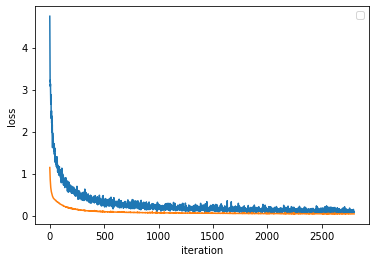

In [453]:
# Plotting train and validation loss vs iterations (Blue train, orange test)

plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(x,train_l)
plt.plot(x,validation_l)

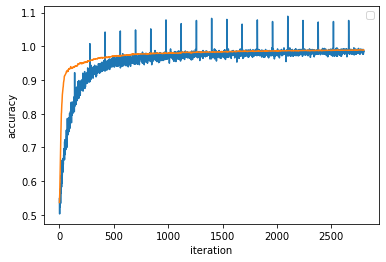

In [454]:
# Plotting train and validation accuracy vs iterations (Blue train, orange test)

plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.plot(x,train_acc)
plt.plot(x,valid_acc)

1. Tree based methods apart from xgboost like decision tree are probably overfiting, overfitting can be reduced by decreasing max depth.
2. Naive bayes looks to be performing well
3. Also mlp classifier was tested and with droupout, it had good accuracy. The loss vs iteration plot also, shows
there is less overfitting.

So the three models which will be evaluated on the test set will be 4 layer neural network, naive bayes, xgboost.


In [455]:
def test(data,method,model,model_name):
    
    '''
    Function to check accuracy on the test dataset.
    '''
    test_dat = data.copy()
    original=test_dat["mixed"].isna()
    # test_dat = fillNa(test_dat,method)
    test_dat["category"]=labe.fit_transform(test_dat["category"])
    
    X,y=getxY(test_dat)
    if model_name=="nn":
        return X,y
    prediction=model.predict(X).reshape((1,-1))
    if method==2:
        prediction=prediction|original.astype("int").values.reshape((1,-1))
    same = prediction.reshape((-1,1))==y
    score = (same.sum()/prediction.shape[0])
    print("{} model accuracy:{}".format(model_name,score))
    return prediction

In [456]:
for model_name in trained_models.keys():
    model = trained_models[model_name]
    test(test_data,2,model,model_name)
    print("-------------------------------")

processed
embedding of sentence calculated
1.0148978233337402 seconds taken
XGB model accuracy:79.0
-------------------------------
processed
embedding of sentence calculated
0.995905876159668 seconds taken
Logistice Regression model accuracy:82.0
-------------------------------
processed
embedding of sentence calculated
0.9933178424835205 seconds taken
Gaussian NB model accuracy:78.0
-------------------------------
processed
embedding of sentence calculated
0.9890074729919434 seconds taken
Random Forest model accuracy:82.0
-------------------------------
processed
embedding of sentence calculated
0.9863526821136475 seconds taken
Decision Tree model accuracy:74.0
-------------------------------
processed
embedding of sentence calculated
0.9959993362426758 seconds taken
K-nearest model accuracy:75.0
-------------------------------
processed
embedding of sentence calculated
1.0080718994140625 seconds taken
multi layer perceptron model accuracy:78.0
-------------------------------


In [457]:
def evaluateNN(da,p):
    X,y=test(da,1,1,"nn")
    # print(X.shape,y.shape)
    net.load_state_dict(torch.load("20.pth",map_location=torch.device('cpu')))
    net.to(device)
    prediction=np.round(net(torch.tensor(X).to(device)).detach().cpu().numpy())
    acc = (prediction.astype("int")==y).sum()/prediction.shape[0]
    print("{:.2f} percent accuracy".format(acc*100))

# As we saw XG BOOST, naive bayes random forest and mlp classifier performed good on the test dataset.

In [458]:
evaluateNN(test_data,None)

processed
embedding of sentence calculated
0.9936578273773193 seconds taken
89.13 percent accuracy


In [459]:
# psuedo labelling can also be explored --> put the labels which are correctly classified in the train set.

In [460]:
# Maybe making a ensemble of the best performing models can be robust.

In [485]:
def ensemble(test_data):
    tX,ty=test(test_data,1,1,'nn')
    probs=[]
    ln=None
    net.load_state_dict(torch.load("50.pth",map_location=torch.device('cpu')))
    net.to(device)
    res = net(torch.tensor(tX))
    ln=res.detach().cpu().numpy()
    for model_name in ["XGB","Logistice Regression","Gaussian NB"]:
        probabilities = trained_models[model_name].predict_proba(tX)
        probs.append(probabilities)
    return probs,ln

In [486]:
result,ln = ensemble(test_data)

processed
embedding of sentence calculated
0.9884953498840332 seconds taken


In [487]:
final = np.zeros((92,2))

In [488]:
for i in result:
    final+=i

In [489]:
test_data[(ln==final.argmax(axis=1).reshape((-1,1)))]# all the ones have common prediction is S category.

,category,mixed
1,1,ASM Community Advertising Online adverstisemtn...
2,1,Application Services Application Services incl...
3,1,Carpet Repairs
5,1,Brandywine Valley Chapter - Metallurgy for the...
7,1,Vct Floor Refinishing
9,1,Assets for Snagit Hosted software service that...
11,1,Clean Carpet - Clean Windows - Scrub And Buff ...
12,1,"Photography Services B2B, outsourced photograp..."
13,1,Identity restoration Personal/Professional ser...
14,1,Set Up and Implementation Services All Set Up ...


In [490]:
# Let us now find which model performs the best on the rest of the data

In [491]:
other_test=test_data[(ln!=final.argmax(axis=1).reshape((-1,1)))]

In [492]:
other_test.shape

(51, 2)

In [493]:
evaluateNN(other_test.reset_index(),(ln!=final.argmax(axis=1).reshape((-1,1))))

processed
embedding of sentence calculated
0.4878253936767578 seconds taken
86.27 percent accuracy


In [494]:
# Testing the other models on the data whose results on models matched
for model_name in trained_models.keys():
    model = trained_models[model_name]
    test(other_test.reset_index(),2,model,model_name)

processed
embedding of sentence calculated
0.48753786087036133 seconds taken
XGB model accuracy:39.0
processed
embedding of sentence calculated
0.48508310317993164 seconds taken
Logistice Regression model accuracy:42.0
processed
embedding of sentence calculated
0.4846515655517578 seconds taken
Gaussian NB model accuracy:39.0
processed
embedding of sentence calculated
0.49184727668762207 seconds taken
Random Forest model accuracy:43.0
processed
embedding of sentence calculated
0.5021135807037354 seconds taken
Decision Tree model accuracy:37.0
processed
embedding of sentence calculated
0.4916419982910156 seconds taken
K-nearest model accuracy:36.0
processed
embedding of sentence calculated
0.4873659610748291 seconds taken
multi layer perceptron model accuracy:38.0


In [495]:
# Will be using the 4 layer neural network.

In [496]:
def make_submission():
    net.load_state_dict(torch.load("50.pth",map_location=torch.device('cpu')))
    net.to(device)
    res = net(torch.tensor(tX))
    ln=res.detach().cpu().numpy()
    prediction = np.round(ln).astype("int")
    test_data=pd.read_csv("test1.csv",sep="\t")
    new_col = pd.DataFrame({"prediction":prediction[:,0]})["prediction"].map({0:"R",1:"S"})
    pd.concat([test_data,new_column],axis=1).to_csv("submission.csv",index=False)

In [497]:
make_submission()

In [498]:
df = pd.read_csv("submission.csv")

In [499]:
(df["category"]==df["prediction"]).sum()/len(prediction)

0.8913043478260869

In [476]:
# 89 % accuracy on the test set.

In [500]:
df

,title,description,category,prediction
0,Myo-Aid,Human Nutritional Supplements/Vitamin Supplements,R,R
1,ASM Community Advertising,Online adverstisemtn on one of ASM electronic ...,S,S
2,Application Services,"Application Services include access to, and us...",S,S
3,Carpet Repairs,NaN,S,S
4,Bio-Sponge®,Human Nutritional Supplements/Vitamin Supplements,R,R
5,Brandywine Valley Chapter - Metallurgy for the...,Education courses delivered onsite at customer...,S,S
6,Remove Suction Line Drier,Remove Suction Line Drier <br/><br/> Reclaim a...,S,S
7,Vct Floor Refinishing,NaN,S,S
8,UniquepH Multipurpose Solution for Rigid Gas P...,"4oz bottles, 2.5 oz bottles for sale\n2.5 oz s...",R,R
9,Assets for Snagit,Hosted software service that allows subscriber...,S,S



**THINGS WHICH CAN BE DONE TO IMPROVE ACCURACY**
1. Since a sentence like "man bites dog" and "dog bites man" both these sentences have the same words(considering the inverse frequency term is irrelevant for some time) then the average embedding of the two sentences will be same, but it is not correct. To consider this, we have to use a model which considers the order of the words(Like LSTM).

2. Train on the entire data.

3. Use higher dimensional embedding( I used 100 dimensional)